In [ ]:
# person r linear coeefecient TO MOŻLIWE ALE DO ZASTANOWIENIA SIE
# mean absolute error NIE WIADOMO CZY ROBIMY CZY NIE
# polynomial features NIE ROBIMY

In [ ]:
!git clone https://github.com/fzamberlan/dmtreg.git > /dev/null 2>&1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import KFold,train_test_split,cross_val_score,GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.gaussian_process.kernels import RBF
from sklearn.feature_selection import SelectKBest, SelectFdr, r_regression
from sklearn.pipeline import make_pipeline
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.impute import SimpleImputer

In [ ]:
from copy import deepcopy
# E - Extraversion/Extroversion
# A - Agreeableness
# C - Conscientiousness
# N - Neuroticism
# O - Openness

p_E = [29, 27, 29, 28, 23, 24, 33, 39, 32, 28, 33, 32, 21, 25, 26, 28, 28, 36, 29, 32, 32, 27, 29, 28, 18, 29, 23, 32]
p_A = [40, 29, 35, 36, 32, 32, 45, 42, 36, 31, 35, 41, 37, 29, 31, 35, 33, 36, 22, 41, 37, 35, 32, 27, 29, 30, 34, 36]
p_C = [29, 31, 29, 31, 25, 31, 31, 22, 29, 33, 23, 37, 31, 31, 34, 37, 26, 30, 30, 39, 40, 34, 30, 26, 24, 26, 22, 17]
p_N = [16, 23, 17, 20, 15, 24, 16, 28, 20, 28, 10, 21, 16, 25, 17, 18, 22, 21, 24, 18, 22, 15, 19, 32, 23, 18, 12, 13]
p_O = [47, 45, 42, 41, 44, 35, 46, 38, 41, 38, 42, 42, 43, 39, 41, 47, 47, 42, 49, 43, 44, 47, 45, 42, 46, 40, 36, 44]

b_E = [29, 23, 28, 27, 28, 26, 34, 39, 32, 28, 34, 35, 22, 26, 30, 31, 33, 36, 29, 37, 32, 26, 30, 23, 25, 31, 23, 31]
b_A = [41, 32, 37, 37, 37, 34, 44, 43, 35, 37, 36, 41, 38, 30, 33, 40, 35, 36, 24, 41, 38, 37, 37, 27, 33, 33, 32, 34]
b_C = [32, 29, 27, 28, 29, 28, 33, 19, 31, 35, 23, 38, 33, 33, 36, 39, 29, 29, 28, 39, 38, 35, 31, 23, 26, 26, 23, 21]
b_N = [15, 28, 17, 18, 17, 24, 17, 27, 20, 26, 11, 22, 20, 27, 13, 13, 25, 19, 21, 20, 20, 14, 19, 34, 16, 13, 18, 15]
b_O = [42, 45, 40, 44, 46, 35, 49, 42, 42, 45, 42, 41, 36, 38, 43, 50, 47, 40, 50, 45, 46, 46, 47, 41, 46, 41, 36, 43]

big_5_pre = np.array( deepcopy([p_E,p_A,p_C,p_N,p_O]) )
big_5_dmt = np.array( deepcopy([b_E,b_A,b_C,b_N,b_O]) )

In [ ]:
bands = {
    "Alpha": pd.read_csv('/content/dmtreg/alpha.csv', header=None),
    "Beta": pd.read_csv('/content/dmtreg/beta.csv', header=None),
    "Delta":  pd.read_csv('/content/dmtreg/delta.csv', header=None),
    "Gamma 1": pd.read_csv('/content/dmtreg/gamma1.csv', header=None),
    "Gamma 2": pd.read_csv('/content/dmtreg/gamma2.csv', header=None),
    "Theta": pd.read_csv('/content/dmtreg/theta.csv', header=None),
    "DMT Alpha": pd.read_csv('/content/dmtreg/DMT_alpha.csv', header=None),
    "DMT Beta": pd.read_csv('/content/dmtreg/DMT_beta.csv', header=None),
    "DMT Delta": pd.read_csv('/content/dmtreg/DMT_delta.csv', header=None),
    "DMT Gamma 1": pd.read_csv('/content/dmtreg/DMT_gamma1.csv', header=None),
    "DMT Gamma 2": pd.read_csv('/content/dmtreg/DMT_gamma2.csv', header=None),
    "DMT Theta": pd.read_csv('/content/dmtreg/DMT_theta.csv', header=None)
}

#Function for renaming rows and columns
def rename(file):
  col_nr = file.shape[1]
  row_nr = len(file)
  file.columns = range(0,col_nr)
  file.index = range(0,row_nr)

#Function for extracting participan
def extracting(file,labels):
  file.drop(
    labels = labels,
    axis = 0 ,
    inplace = True
  )

#Extracting participant 3 from bands
for a in bands.keys():
  extracting(bands[a],[2])

# # Changing the rows and columns names
for a in bands.keys():
  rename(bands[a])

In [ ]:
#SVR pre DMT separate bands

feat_selection = SelectKBest(r_regression)
regressor = SVR(kernel = 'rbf')
pipeline = make_pipeline(feat_selection, regressor)
param_grid = {'svr__C': [0.1, 1, 10], 'svr__gamma': [0.1, 1, 10], 'svr__epsilon': [0.05, 0.2, 0.5, 1.0], 'selectkbest__k': [10, 15, 20]}

# Creating Panda DataFrame to save metric values
results_pre_m1 = []
for k in range(7):
    results_pre_m1.append(pd.DataFrame(columns=["band", "model", "MAE", "pearsonr", "p-value", 'y']))

nr = 0

for band in list(bands.keys())[0:6]:
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(bands[band], big_5_pre[i], test_size = 0.2, random_state = 0, shuffle = True)
        X_train = X_train.values
        X_test = X_test.values

        # Polynomial features
        polynomial_features = PolynomialFeatures(degree = 2, include_bias = True)
        X_train_poly = polynomial_features.fit_transform(X_train)
        X_test_poly = polynomial_features.transform(X_test)

        # Grid search
        grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'r2')
        grid_search.fit(X_train_poly, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_poly)

        score = mean_absolute_error(y_test, y_pred)
        corr_coef, p_value = pearsonr(y_test, y_pred)
        results_pre_m1[nr].loc[i, "band"] = band
        results_pre_m1[nr].loc[i, "model"] = best_model
        results_pre_m1[nr].loc[i, "MAE"] = score
        results_pre_m1[nr].loc[i, "pearsonr"] = corr_coef
        results_pre_m1[nr].loc[i, "p-value"] = p_value
        results_pre_m1[nr].loc[i, "y"] = [y_test, y_pred]

    nr += 1

In [ ]:
#SVR pre DMT all bands concatenated

feat_selection = SelectKBest(r_regression)
regressor = SVR(kernel = 'rbf')
pipeline = make_pipeline(feat_selection, regressor)
param_grid = {'svr__C': [0.1, 1, 10], 'svr__gamma': [0.1, 1, 10], 'svr__epsilon': [0.05, 0.2, 0.5, 1.0], 'selectkbest__k': [10, 150, 200]}


X_train_all = []
X_train_all = np.array(X_train_all)
X_test_all = []
X_test_all = np.array(X_test_all)

for band in list(bands.keys())[0:6]:
    X_train, X_test = train_test_split(bands[band], test_size = 0.2, random_state = 0, shuffle = True)
    X_train = X_train.values
    X_test = X_test.values
    if len(X_train_all) == 0:
        X_train_all = X_train
        X_test_all = X_test
    else:
        X_train_all = np.hstack((X_train_all,X_train))
        X_test_all = np.hstack((X_test_all,X_test))

#Polynomial features for X
polynomial_features = PolynomialFeatures(degree = 2, include_bias = True)
X_train_poly = polynomial_features.fit_transform(X_train_all)
X_test_poly = polynomial_features.transform(X_test_all)

for i in range (5):
    y_train, y_test = train_test_split(big_5_pre[i], test_size = 0.2, random_state = 0, shuffle = True)

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'r2')
    grid_search.fit(X_train_poly, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_poly)

    score = mean_absolute_error(y_test, y_pred)
    corr_coef, p_value = pearsonr(y_test, y_pred)
    results_pre_m1[6].loc[i, "band"] = "All bands pre DMT"
    results_pre_m1[6].loc[i, "model"] = best_model
    results_pre_m1[6].loc[i, "MAE"] = score
    results_pre_m1[6].loc[i, "pearsonr"] = corr_coef
    results_pre_m1[6].loc[i, "p-value"] = p_value
    results_pre_m1[6].loc[i, "y"] = [y_test, y_pred]

In [ ]:
#SVR DMT separate bands

feat_selection = SelectKBest(r_regression)
regressor = SVR(kernel='rbf')
pipeline = make_pipeline(feat_selection, regressor)
param_grid = {'svr__C': [0.1, 1, 10], 'svr__gamma': [0.1, 1, 10], 'svr__epsilon': [0.05, 0.2, 0.5, 1.0], 'selectkbest__k': [10, 15, 20]}

# Creating Panda DataFrame to save metric values
results_dmt_m1 = []
for k in range(7):
    results_dmt_m1.append(pd.DataFrame(columns=["band", "model", "MAE", "pearsonr", "p-value", 'y']))

nr = 0

for band in list(bands.keys())[6:12]:
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(bands[band], big_5_dmt[i], test_size=0.2, random_state=0, shuffle=True)
        X_train = X_train.values
        X_test = X_test.values

        #Polynomial features
        polynomial_features = PolynomialFeatures(degree=2, include_bias=True)
        X_train_poly = polynomial_features.fit_transform(X_train)
        X_test_poly = polynomial_features.transform(X_test)

        # Perform grid search
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
        grid_search.fit(X_train_poly, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_poly)

        score = mean_absolute_error(y_test, y_pred)
        corr_coef, p_value = pearsonr(y_test, y_pred)
        results_dmt_m1[nr].loc[i, "band"] = band
        results_dmt_m1[nr].loc[i, "model"] = best_model
        results_dmt_m1[nr].loc[i, "MAE"] = score
        results_dmt_m1[nr].loc[i, "pearsonr"] = corr_coef
        results_dmt_m1[nr].loc[i, "p-value"] = p_value
        results_dmt_m1[nr].loc[i, "y"] = [y_test, y_pred]

    nr += 1

In [ ]:
#SVR DMT all bands concatenated

feat_selection = SelectKBest(r_regression)
regressor = SVR(kernel='rbf')
pipeline = make_pipeline(feat_selection, regressor)
param_grid = {'svr__C': [0.1, 1, 10], 'svr__gamma': [0.1, 1, 10], 'svr__epsilon': [0.05, 0.2, 0.5, 1.0], 'selectkbest__k': [10, 150, 200]}


X_train_all=[]
X_train_all=np.array(X_train_all)
X_test_all=[]
X_test_all=np.array(X_test_all)

for band in list(bands.keys())[6:12]:
    X_train, X_test = train_test_split(bands[band], test_size = 0.2, random_state = 0, shuffle = True)
    X_train = X_train.values
    X_test = X_test.values
    if len(X_train_all) == 0:
        X_train_all = X_train
        X_test_all = X_test
    else:
        X_train_all = np.hstack((X_train_all,X_train))
        X_test_all = np.hstack((X_test_all,X_test))

#Extracting polynomial features from X
polynomial_features = PolynomialFeatures(degree = 2, include_bias = True)
X_train_poly = polynomial_features.fit_transform(X_train_all)
X_test_poly = polynomial_features.transform(X_test_all)

for i in range (5):
    y_train, y_test = train_test_split(big_5_dmt[i], test_size = 0.2, random_state = 0, shuffle = True)

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train_poly, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_poly)

    score = mean_absolute_error(y_test, y_pred)
    corr_coef, p_value = pearsonr(y_test, y_pred)
    results_dmt_m1[6].loc[i, "band"] = "All bands DMT"
    results_dmt_m1[6].loc[i, "model"] = best_model
    results_dmt_m1[6].loc[i, "MAE"] = score
    results_dmt_m1[6].loc[i, "pearsonr"] = corr_coef
    results_dmt_m1[6].loc[i, "p-value"] = p_value
    results_dmt_m1[6].loc[i, "y"] = [y_test, y_pred]

In [ ]:
#SVR concatenated bands, models performance comparison

model_info_svr = []
big_5_features = ["Extraversion/Extroversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness"]

for i in range(5):
    pipeline = results_pre_m1[6]['model'][i]
    model = pipeline.named_steps['svr']
    model_name = model.__class__.__name__
    score = [round(results_pre_m1[6].loc[i, "MAE"],3),round(results_dmt_m1[6].loc[i, "MAE"],3)]
    score_difference=round(results_dmt_m1[6].loc[i, "MAE"],3)-round(results_pre_m1[6].loc[i, "MAE"],3)
    corr_coef = [round(results_pre_m1[6].loc[i, "pearsonr"],3),round(results_dmt_m1[6].loc[i, "pearsonr"],3)]
    p_value = [round(results_pre_m1[6].loc[i, "p-value"],3),round(results_dmt_m1[6].loc[i, "p-value"],3)]

    model_dict_svr = {
        "Model": model_name,
        "band": "All bands before and after DMT",
        "Big 5":big_5_features[i],
        "pearsonr": corr_coef,
        "p-value": p_value,
        "MAE": score,
        "∆ MAE":score_difference
    }
    model_info_svr.append(model_dict_svr)

model_df_svr = pd.DataFrame(model_info_svr)
display(model_df_svr)

Model                            band                      Big 5  \
0   SVR  All bands before and after DMT  Extraversion/Extroversion   
1   SVR  All bands before and after DMT              Agreeableness   
2   SVR  All bands before and after DMT          Conscientiousness   
3   SVR  All bands before and after DMT                Neuroticism   
4   SVR  All bands before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0    [0.336, -0.66]  [0.515, 0.154]  [3.167, 3.467]  0.300  
1   [0.032, -0.148]  [0.952, 0.779]    [2.674, 2.0] -0.674  
2    [0.272, 0.252]   [0.602, 0.63]  [2.228, 3.481]  1.253  
3    [0.814, 0.333]  [0.049, 0.519]  [1.627, 2.906]  1.279  
4  [-0.767, -0.601]  [0.075, 0.207]    [2.5, 3.993]  1.493

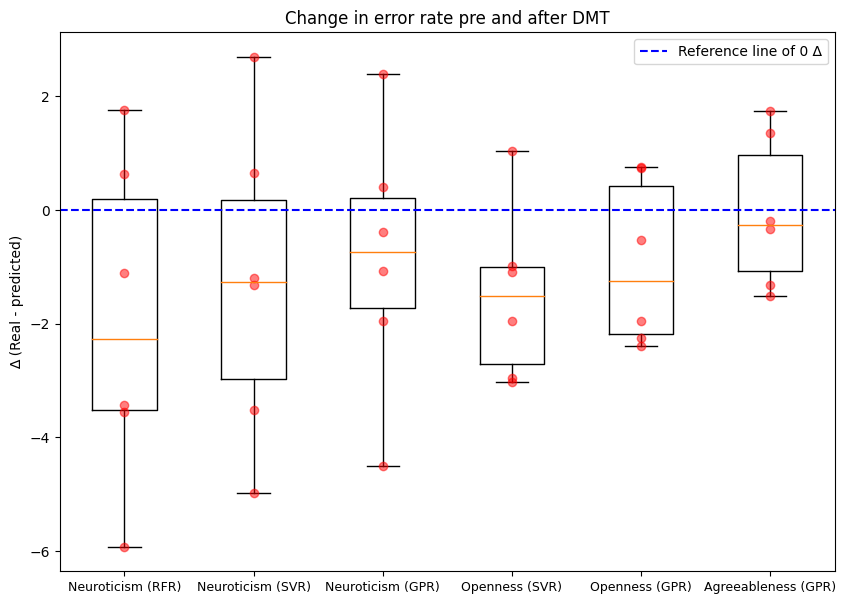

In [ ]:
# Sample data (mean absolute errors)
neuroticism = neuroticism_svr
agreeableness = [0.9, 1.1, 1.3, 1.5, 1.7, 1.8]
openness = [1.0, 1.3, 1.6, 1.9]

# Create a list of data for the box plot
data = [neuroticism_rfr[0], neuroticism_svr[0], neuroticism_gpr[0], openness_svr[0], openness_gpr[0], agreeableness_gpr[0]]

# Labels for the x-axis
labels = [
    'Neuroticism (RFR)',
    'Neuroticism (SVR)',
    'Neuroticism (GPR)',
    'Openness (SVR)',
    'Openness (GPR)',
    'Agreeableness (GPR)'
]
# Create the box plot
plt.figure(figsize = (10, 7))
plt.boxplot(data, labels=labels)
plt.ylabel('∆ (Real - predicted)')
plt.xticks(range(1, len(labels) + 1), labels, fontsize = 9)
plt.axhline(y = 0, color = 'blue', linestyle = 'dashed', label = "Reference line of 0 ∆")
plt.legend()
plt.title('Change in error rate pre and after DMT')

for i, d in enumerate(data):
    y = d
    x = [i+1] * len(y)
    plt.plot(x, y, 'ro', alpha=0.5)

# Display the plot
plt.show()


In [ ]:
features = ["Extraversion/Extroversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness"]
neuroticism_svr = []
openness_svr = []

neuroticism_rfr = []

agreeableness_gpr = []
neuroticism_gpr = []
openness_gpr = []



for i in range(5):
  if i == 3:
    y_test_pre = results_pre_m1[6]['y'][i][0]
    y_pred_pre = results_pre_m1[6]['y'][i][1]
    y_error_pre = abs(abs(y_test_pre) - abs(y_pred_pre))
    y_test_dmt = results_dmt_m1[6]['y'][i][0]
    y_pred_dmt = results_dmt_m1[6]['y'][i][1]
    y_error_dmt = abs(abs(y_test_dmt) - abs(y_pred_dmt))
    y_error = np.round(y_error_pre - y_error_dmt, 5)
    neuroticism_svr.append(y_error)
  if i == 4:
    y_test_pre = results_pre_m1[6]['y'][i][0]
    y_pred_pre = results_pre_m1[6]['y'][i][1]
    y_error_pre = abs(abs(y_test_pre) - abs(y_pred_pre))
    y_test_dmt = results_dmt_m1[6]['y'][i][0]
    y_pred_dmt = results_dmt_m1[6]['y'][i][1]
    y_error_dmt = abs(abs(y_test_dmt) - abs(y_pred_dmt))
    y_error = np.round(y_error_pre - y_error_dmt, 5)
    openness_svr.append(y_error)
  else:
    continue

print(neuroticism_svr)
print( openness_svr )


for i in range(5):
    if i == 3:
      y_test_pre = results_pre_m2[6]['y'][i][0]
      y_pred_pre = results_pre_m2[6]['y'][i][1]
      y_error_pre = abs(abs(y_test_pre) - abs(y_pred_pre))
      y_test_dmt = results_dmt_m2[6]['y'][i][0]
      y_pred_dmt = results_dmt_m2[6]['y'][i][1]
      y_error_dmt = abs(abs(y_test_dmt) - abs(y_pred_dmt))
      y_error = np.round(y_error_pre - y_error_dmt, 5)
      neuroticism_rfr.append( y_error )
    else:
      continue

print( neuroticism_rfr )

for i in range(5):
    if i == 1:
      y_test_pre = results_pre_m3[6]['y'][i][0]
      y_pred_pre = results_pre_m3[6]['y'][i][1]
      y_error_pre = abs(abs(y_test_pre) - abs(y_pred_pre))
      y_test_dmt = results_dmt_m3[6]['y'][i][0]
      y_pred_dmt = results_dmt_m3[6]['y'][i][1]
      y_error_dmt = abs(abs(y_test_dmt) - abs(y_pred_dmt))
      y_error = np.round(y_error_pre - y_error_dmt, 5)
      agreeableness_gpr.append( y_error )
    if i == 3:
      y_test_pre = results_pre_m3[6]['y'][i][0]
      y_pred_pre = results_pre_m3[6]['y'][i][1]
      y_error_pre = abs(abs(y_test_pre) - abs(y_pred_pre))
      y_test_dmt = results_dmt_m3[6]['y'][i][0]
      y_pred_dmt = results_dmt_m3[6]['y'][i][1]
      y_error_dmt = abs(abs(y_test_dmt) - abs(y_pred_dmt))
      y_error = np.round(y_error_pre - y_error_dmt, 5)
      neuroticism_gpr.append( y_error )
    if i == 4:
      y_test_pre = results_pre_m3[6]['y'][i][0]
      y_pred_pre = results_pre_m3[6]['y'][i][1]
      y_error_pre = abs(abs(y_test_pre) - abs(y_pred_pre))
      y_test_dmt = results_dmt_m3[6]['y'][i][0]
      y_pred_dmt = results_dmt_m3[6]['y'][i][1]
      y_error_dmt = abs(abs(y_test_dmt) - abs(y_pred_dmt))
      y_error = np.round(y_error_pre - y_error_dmt, 5)
      openness_gpr.append( y_error )
    else:
      continue

print( agreeableness_gpr )
print( neuroticism_gpr )
print( type(openness_gpr[0]) )
openness_gpr = list(openness_gpr)
print(type( openness_gpr) )

[array([-1.311  ,  0.64544, -4.98554,  2.69893, -3.52037, -1.20245])]
[array([-3.03278, -1.08508,  1.04673, -2.95356, -0.97855, -1.95406])]
[array([-3.42567,  1.76633, -3.55867, -1.10867, -5.926  ,  0.62917])]
[array([-0.33471, -1.51406, -0.19188,  1.74956, -1.31648,  1.3563 ])]
[array([-0.3851 ,  0.41175, -4.4974 ,  2.39275, -1.94593, -1.07863])]
<class 'numpy.ndarray'>
<class 'list'>


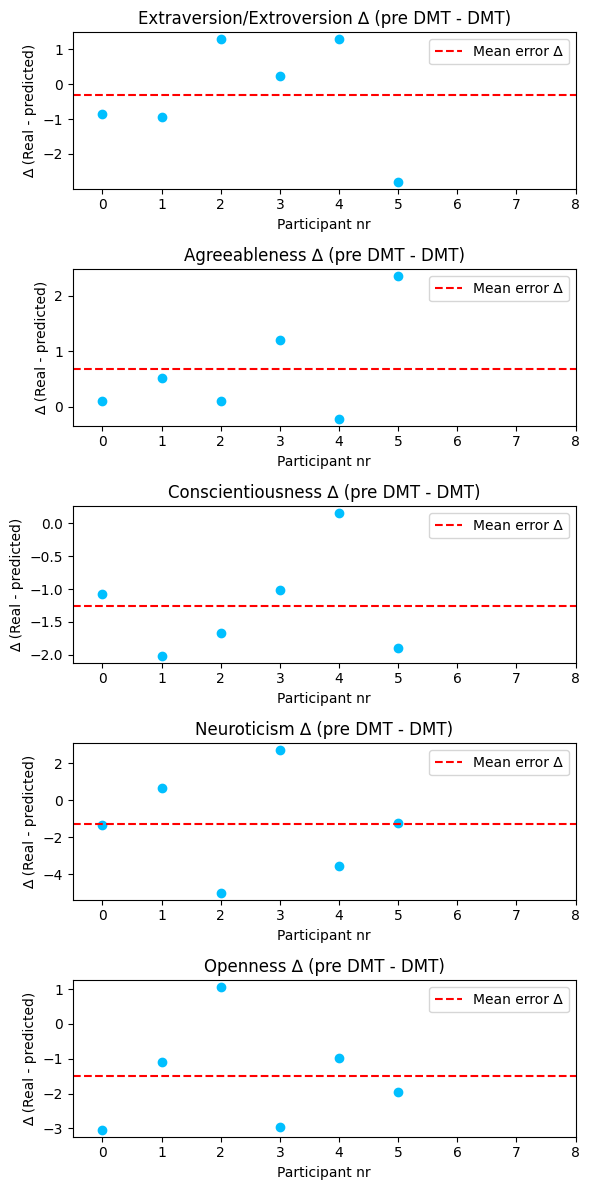

In [ ]:
#SVR concatenated bands, plotting

results_difference_m1 = []
for k in range(7):
    results_difference_m1.append( pd.DataFrame( columns = ["model", "bands", "Big 5", "pearsonr", "p-value", "MAE", "∆ MAE"] ) )

big_5_features = ["Extraversion/Extroversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness"]

fig, axes = plt.subplots(5, 1, figsize=(6, 12))

# y_error_list
for i in range(5):
    y_test_pre = results_pre_m1[6]['y'][i][0]
    y_pred_pre = results_pre_m1[6]['y'][i][1]
    y_error_pre = abs(abs(y_test_pre) - abs(y_pred_pre))
    y_test_dmt = results_dmt_m1[6]['y'][i][0]
    y_pred_dmt = results_dmt_m1[6]['y'][i][1]
    y_error_dmt = abs(abs(y_test_dmt) - abs(y_pred_dmt))
    y_error = np.round(y_error_pre - y_error_dmt, 5)

    ax = axes[i]
    ax.scatter(range(0, 6), y_error, color = "deepskyblue")
    ax.set_xlim(-0.5, 8)
    ax.set_title(big_5_features[i] + " ∆ (pre DMT - DMT)")
    ax.set_xlabel("Participant nr")
    ax.set_ylabel("∆ (Real - predicted)")

    mean_difference = np.mean(y_error)
    ax.axhline(mean_difference, color = "red", linestyle = "--", label = "Mean error ∆")
    ax.legend()

fig.tight_layout()
plt.show()

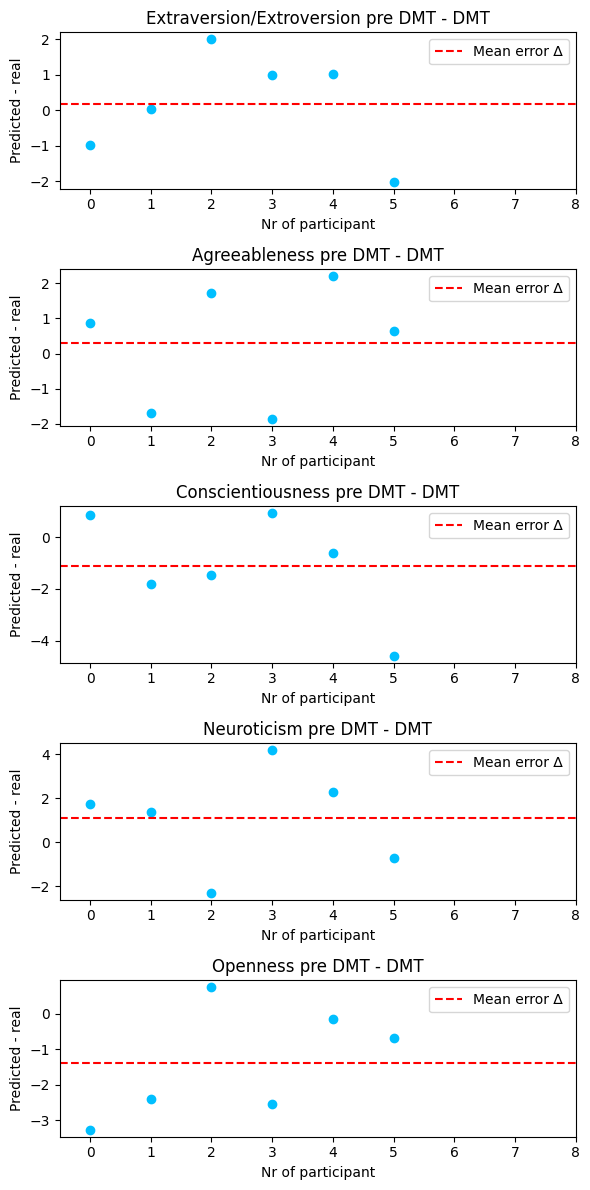

model                       bands                      Big 5  \
0   SVR  Alpha before and after DMT  Extraversion/Extroversion   
1   SVR  Alpha before and after DMT              Agreeableness   
2   SVR  Alpha before and after DMT          Conscientiousness   
3   SVR  Alpha before and after DMT                Neuroticism   
4   SVR  Alpha before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0     (0.156, 0.01)  (0.768, 0.985)   [3.167, 2.99] -0.177  
1    (0.796, 0.504)  (0.058, 0.308)   [2.422, 2.11] -0.312  
2    (0.563, 0.119)  (0.245, 0.822)  [2.229, 3.348]  1.119  
3   (-0.844, 0.022)  (0.035, 0.967)  [3.763, 2.675] -1.088  
4  (-0.014, -0.583)  (0.979, 0.225)  [2.703, 4.085]  1.382

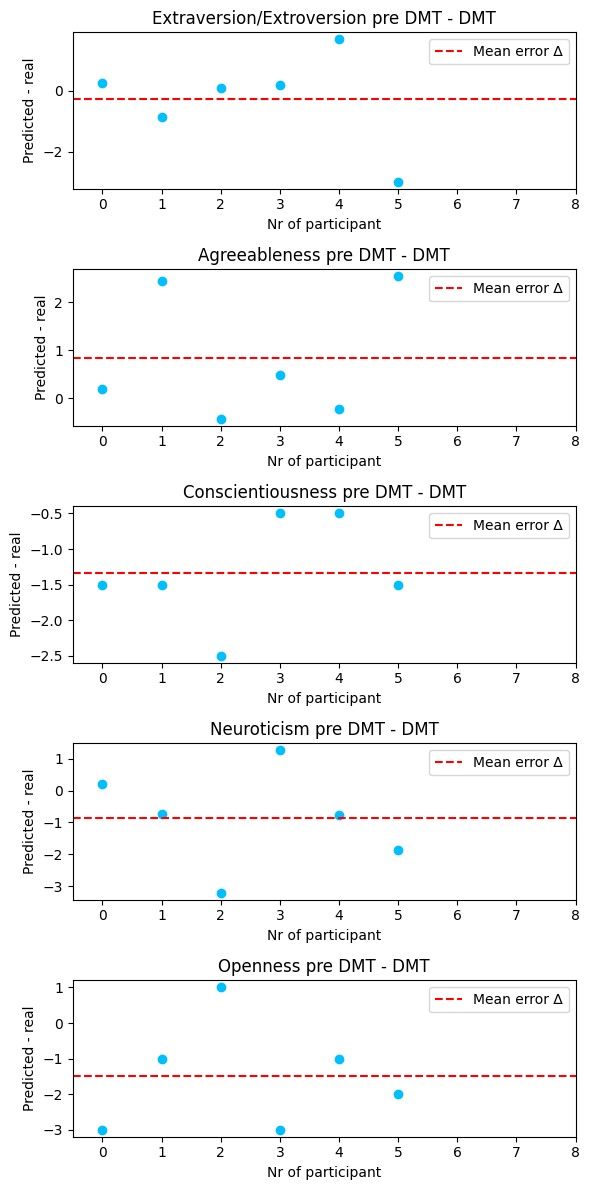

model                      bands                      Big 5  \
0   SVR  Beta before and after DMT  Extraversion/Extroversion   
1   SVR  Beta before and after DMT              Agreeableness   
2   SVR  Beta before and after DMT          Conscientiousness   
3   SVR  Beta before and after DMT                Neuroticism   
4   SVR  Beta before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0  (-0.277, -0.679)  (0.595, 0.138)  [3.348, 3.628]   0.28  
1    (0.335, 0.399)  (0.517, 0.434)    [2.833, 2.0] -0.834  
2     (-0.58, 0.58)  (0.228, 0.227)    [2.167, 3.5]  1.333  
3    (0.801, 0.557)  (0.055, 0.251)  [2.076, 2.923]  0.847  
4  (-0.944, -0.765)  (0.005, 0.076)      [2.5, 4.0]    1.5

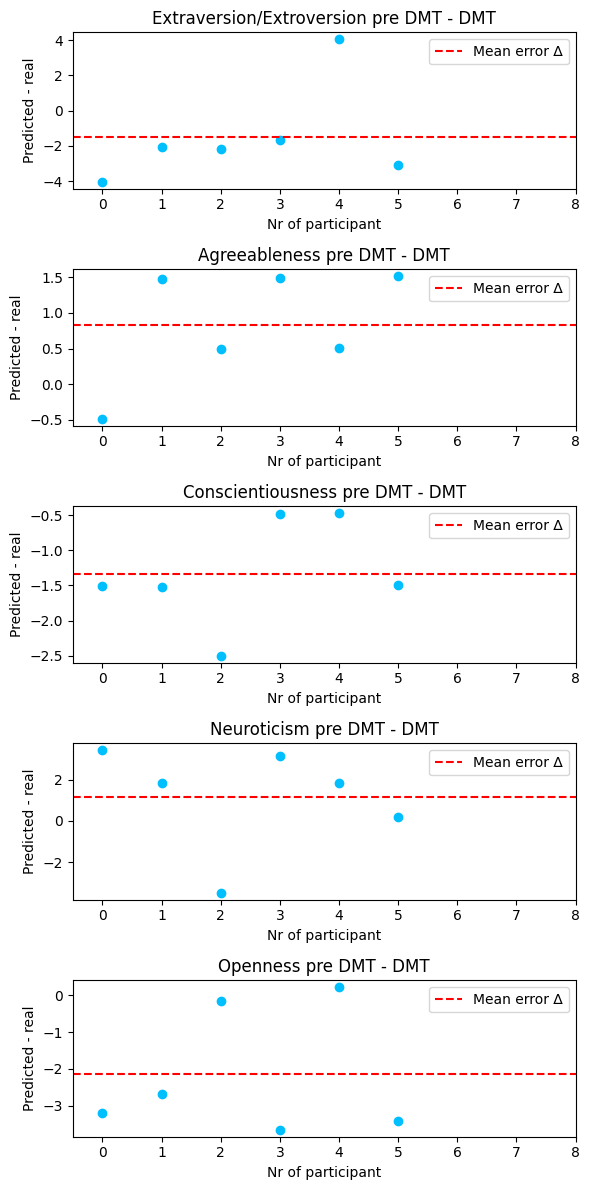

model                       bands                      Big 5  \
0   SVR  Delta before and after DMT  Extraversion/Extroversion   
1   SVR  Delta before and after DMT              Agreeableness   
2   SVR  Delta before and after DMT          Conscientiousness   
3   SVR  Delta before and after DMT                Neuroticism   
4   SVR  Delta before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0  (-0.367, -0.139)  (0.475, 0.793)  [3.167, 4.656]  1.489  
1    (-0.29, 0.274)  (0.577, 0.599)  [2.833, 1.998] -0.835  
2   (-0.037, 0.129)  (0.945, 0.808)  [2.172, 3.502]   1.33  
3   (-0.725, -0.35)  (0.103, 0.496)  [3.836, 2.668] -1.168  
4  (-0.103, -0.257)  (0.846, 0.623)  [2.334, 4.483]  2.148

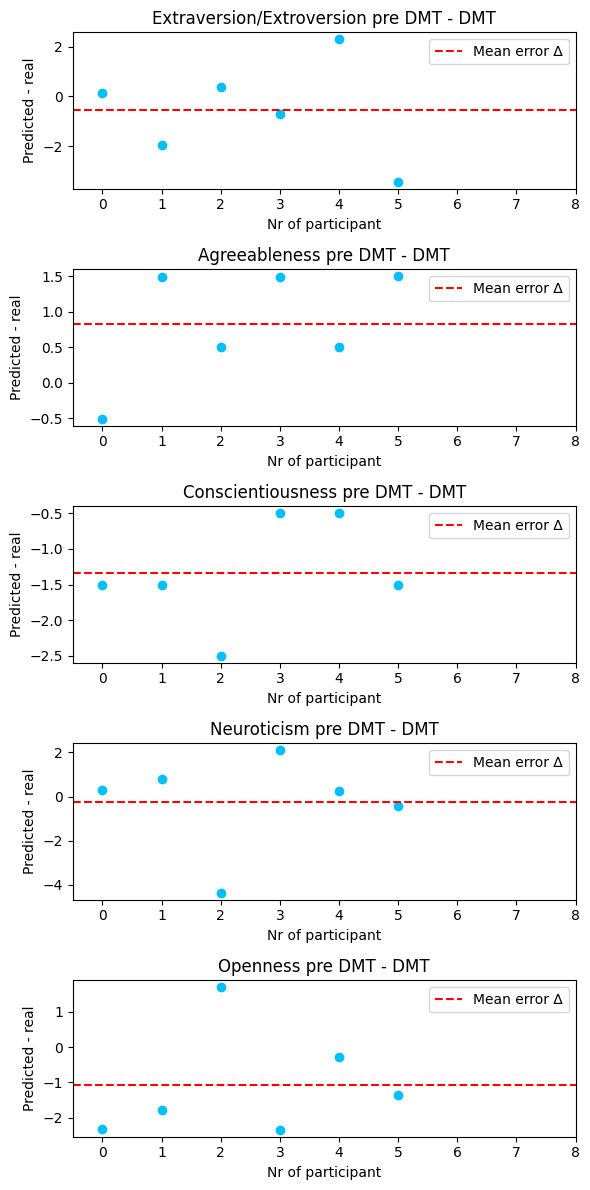

model                         bands                      Big 5  \
0   SVR  Gamma 1 before and after DMT  Extraversion/Extroversion   
1   SVR  Gamma 1 before and after DMT              Agreeableness   
2   SVR  Gamma 1 before and after DMT          Conscientiousness   
3   SVR  Gamma 1 before and after DMT                Neuroticism   
4   SVR  Gamma 1 before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0  (-0.208, -0.388)  (0.692, 0.447)  [3.167, 3.717]   0.55  
1   (0.832, -0.131)   (0.04, 0.804)  [2.833, 2.003]  -0.83  
2  (-0.633, -0.612)  (0.177, 0.196)    [2.167, 3.5]  1.333  
3   (-0.193, 0.602)  (0.714, 0.206)  [2.439, 2.667]  0.228  
4    (0.069, -0.53)  (0.897, 0.279)  [2.939, 4.004]  1.065

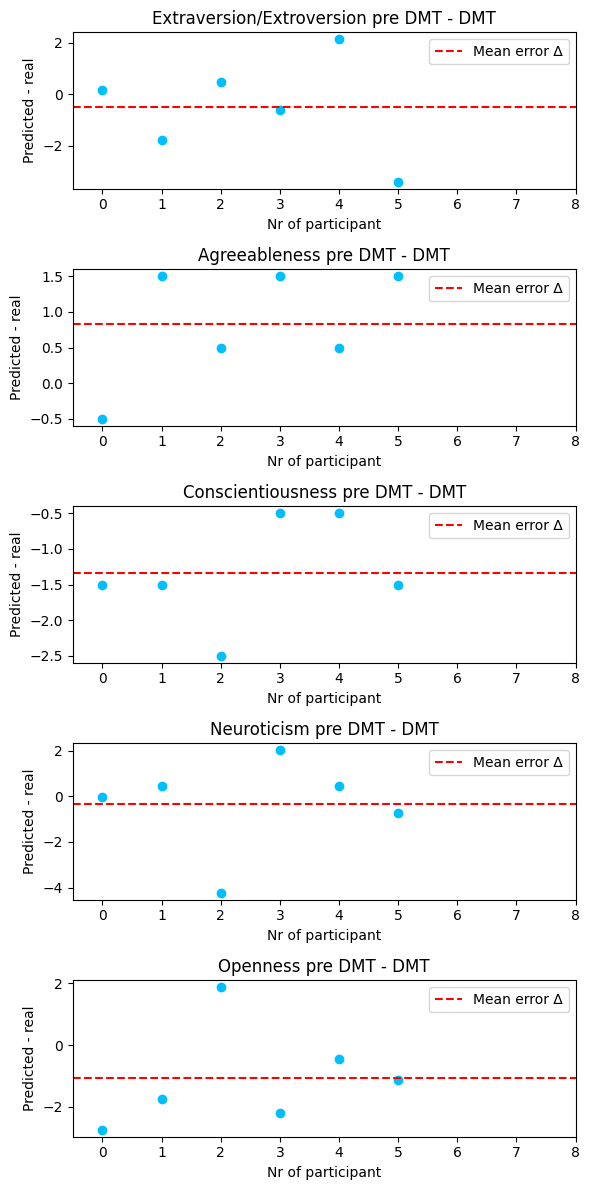

model                         bands                      Big 5  \
0   SVR  Gamma 2 before and after DMT  Extraversion/Extroversion   
1   SVR  Gamma 2 before and after DMT              Agreeableness   
2   SVR  Gamma 2 before and after DMT          Conscientiousness   
3   SVR  Gamma 2 before and after DMT                Neuroticism   
4   SVR  Gamma 2 before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0   (0.357, -0.527)  (0.488, 0.282)  [3.167, 3.663]  0.496  
1   (0.834, -0.187)  (0.039, 0.723)    [2.833, 2.0] -0.833  
2  (-0.614, -0.649)  (0.195, 0.163)    [2.167, 3.5]  1.333  
3   (-0.299, 0.396)  (0.565, 0.438)  [2.344, 2.691]  0.347  
4   (0.078, -0.467)   (0.883, 0.35)  [2.973, 4.039]  1.066

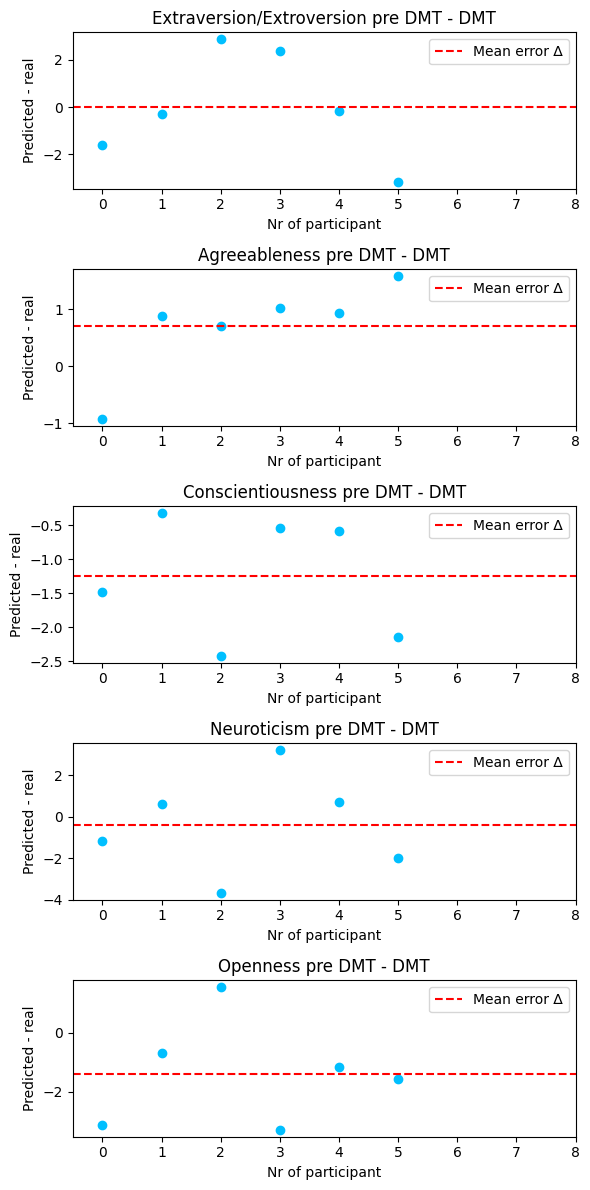

model                       bands                      Big 5  \
0   SVR  Theta before and after DMT  Extraversion/Extroversion   
1   SVR  Theta before and after DMT              Agreeableness   
2   SVR  Theta before and after DMT          Conscientiousness   
3   SVR  Theta before and after DMT                Neuroticism   
4   SVR  Theta before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0  (-0.422, -0.435)  (0.405, 0.389)  [3.299, 3.292] -0.007  
1    (0.907, 0.438)  (0.012, 0.385)  [2.833, 2.135] -0.698  
2   (-0.105, -0.27)  (0.843, 0.605)  [2.167, 3.416]   1.25  
3  (-0.024, -0.151)  (0.965, 0.775)  [2.275, 2.667]  0.392  
4  (-0.036, -0.191)  (0.947, 0.717)    [2.618, 4.0]  1.382

In [ ]:
#SVR differences by bands

bands_list = list(bands.keys())
big_5_features = ["Extraversion/Extroversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness"]

for band in range(6):
    fig, axes = plt.subplots(5, 1, figsize=(6, 12))
    for i in range(5):

        #Comparing model performance before and after DMT
        results_difference_m1[band].loc[i, "model"] = "SVR"
        results_difference_m1[band].loc[i, "Big 5"] = big_5_features[i]
        results_difference_m1[band].loc[i, "bands"] = "{} before and after DMT".format(bands_list[band])
        results_difference_m1[band].loc[i, "MAE"] = str([round(results_pre_m1[band].loc[i, 'MAE'],3),round(results_dmt_m1[band].loc[i, 'MAE'],3)])
        results_difference_m1[band].loc[i, "∆ MAE"] = round(results_dmt_m1[band].loc[i, 'MAE'] - results_pre_m1[band].loc[i, 'MAE'],3)
        results_difference_m1[band].loc[i, "pearsonr"] = str((round(results_pre_m1[band].loc[i, 'pearsonr'], 3),
                                                    round(results_dmt_m1[band].loc[i, 'pearsonr'], 3)))
        results_difference_m1[band].loc[i, "p-value"] = str((round(results_pre_m1[band].loc[i, 'p-value'], 3),
                                                   round(results_dmt_m1[band].loc[i, 'p-value'], 3)))

        #Calculating error before DMT
        y_test_pre = results_pre_m1[band]['y'][i][0]
        y_pred_pre = results_pre_m1[band]['y'][i][1]
        y_error_pre = abs(abs(y_test_pre) - abs(y_pred_pre))

        #Calcualting error after DMT
        y_test_dmt = results_dmt_m1[band]['y'][i][0]
        y_pred_dmt = results_dmt_m1[band]['y'][i][1]
        y_error_dmt = abs(abs(y_test_dmt) - abs(y_pred_dmt))

        #Calculating imporvement in performance after DMT
        y_error_change_list = []
        y_error_change = np.round(y_error_pre - y_error_dmt, 5)
        y_error_change_list.append(y_error_change)

        #Plotting resoults
        ax = axes[i]
        ax.scatter(range(0, 6), y_error_change, color="deepskyblue")
        ax.set_xlim(-0.5, 8)

        ax.set_title(big_5_features[i] + " pre DMT - DMT")
        ax.set_xlabel("Nr of participant")
        ax.set_ylabel("Predicted - real")
        ax.plot()

        # Adding line to show mean change in the error rate.
        # Line above 0 indicates imporvement in performance and drop of the error rate after DMT
        mean_difference = np.mean(y_error_change_list)
        ax.axhline(mean_difference, color = "red", linestyle = "--", label = "Mean error ∆")
        ax.legend()

    fig.tight_layout()
    plt.show()
    display(results_difference_m1[band])


In [ ]:
# Random Forest pre DMT seperate bands

feat_selection = SelectKBest(r_regression)
regressor = RandomForestRegressor( bootstrap = False, random_state = 0 )
pipeline = make_pipeline(feat_selection, regressor)
param_grid = {'randomforestregressor__n_estimators': [ 100, 200, 500], 'randomforestregressor__max_depth': [4, 6, 8], 'selectkbest__k': [10, 15, 20]}

#creating Panda DataFrame to save metric values
results_pre_m2 = []
for k in range(7):
  results_pre_m2.append( pd.DataFrame(columns = ["band", "model", "MAE", "pearsonr", "p-value", 'y']) )

nr = 0

for band in list(bands.keys())[0:6]:
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(bands[band], big_5_pre[i], test_size = 0.2, random_state = 0, shuffle = True)
        X_train = X_train.values
        X_test = X_test.values

        # Polynomial features
        polynomial_features = PolynomialFeatures(degree = 2, include_bias = True)
        X_train_poly = polynomial_features.fit_transform(X_train)
        X_test_poly = polynomial_features.transform(X_test)

        # Grid search
        grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'r2')
        grid_search.fit(X_train_poly, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_poly)

        score = mean_absolute_error(y_test, y_pred)
        corr_coef, p_value = pearsonr(y_test, y_pred)
        results_pre_m2[nr].loc[i, "band"] = band
        results_pre_m2[nr].loc[i, "model"] = best_model
        results_pre_m2[nr].loc[i, "MAE"] = score
        results_pre_m2[nr].loc[i, "pearsonr"] = corr_coef
        results_pre_m2[nr].loc[i, "p-value"] = p_value
        results_pre_m2[nr].loc[i, "y"] = [y_test, y_pred]

    nr += 1

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
# Random forest pre DMT all bands concatenated

feat_selection = SelectKBest(r_regression)
regressor = RandomForestRegressor( bootstrap = False, random_state = 0 )
pipeline = make_pipeline(feat_selection, regressor)
param_grid = {'randomforestregressor__n_estimators': [100, 200, 500], 'randomforestregressor__max_depth': [4, 6, 8], 'selectkbest__k': [10, 150, 200]}


X_train_all = []
X_train_all = np.array(X_train_all)
X_test_all = []
X_test_all = np.array(X_test_all)

for band in list(bands.keys())[0:6]:
    X_train, X_test = train_test_split(bands[band],  test_size = 0.2, random_state = 0, shuffle = True)
    X_train = X_train.values
    X_test = X_test.values
    if len(X_train_all) == 0:
        X_train_all = X_train
        X_test_all = X_test
    else:
        X_train_all = np.hstack((X_train_all,X_train))
        X_test_all = np.hstack((X_test_all,X_test))

#Polynomial features for X
polynomial_features = PolynomialFeatures( degree = 2, include_bias = True )
X_train_poly = polynomial_features.fit_transform( X_train_all )
X_test_poly = polynomial_features.transform( X_test_all )

for i in range (5):
    y_train, y_test = train_test_split(big_5_pre[i], test_size = 0.2, random_state = 0, shuffle = True)

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'r2')
    grid_search.fit(X_train_poly, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_poly)

    score = mean_absolute_error(y_test, y_pred)
    corr_coef, p_value = pearsonr(y_test, y_pred)
    results_pre_m2[6].loc[i, "band"] = "All bands pre DMT"
    results_pre_m2[6].loc[i, "model"] = best_model
    results_pre_m2[6].loc[i, "MAE"] = score
    results_pre_m2[6].loc[i, "pearsonr"] = corr_coef
    results_pre_m2[6].loc[i, "p-value"] = p_value
    results_pre_m2[6].loc[i, "y"] = [y_test, y_pred]

In [ ]:
# Random Forest DMT seperate bands

feat_selection = SelectKBest(r_regression)
regressor = RandomForestRegressor( bootstrap = False, random_state = 0 )
pipeline = make_pipeline(feat_selection, regressor)
param_grid = {'randomforestregressor__n_estimators': [100, 200, 500], 'randomforestregressor__max_depth': [4, 6, 8], 'selectkbest__k': [10, 15, 20]}

#creating Panda DataFrame to save metric values
results_dmt_m2 = []
for k in range(7):
  results_dmt_m2.append( pd.DataFrame(columns = ["band", "model", "MAE", "pearsonr", "p-value", 'y']) )

nr=0

for band in list(bands.keys())[6:12]:
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(bands[band], big_5_dmt[i], test_size = 0.2, random_state = 0, shuffle = True)
        X_train = X_train.values
        X_test = X_test.values

        #Polynomial features
        polynomial_features = PolynomialFeatures(degree = 2, include_bias = True)
        X_train_poly = polynomial_features.fit_transform(X_train)
        X_test_poly = polynomial_features.transform(X_test)

        # Perform grid search
        grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'r2')
        grid_search.fit(X_train_poly, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_poly)

        score = mean_absolute_error(y_test, y_pred)
        corr_coef, p_value = pearsonr(y_test, y_pred)
        results_dmt_m2[nr].loc[i, "band"] = band
        results_dmt_m2[nr].loc[i, "model"] = best_model
        results_dmt_m2[nr].loc[i, "MAE"] = score
        results_dmt_m2[nr].loc[i, "pearsonr"] = corr_coef
        results_dmt_m2[nr].loc[i, "p-value"] = p_value
        results_dmt_m2[nr].loc[i, "y"] = [y_test, y_pred]

    nr += 1

In [ ]:
# Random forest DMT all bands concatenated

feat_selection = SelectKBest(r_regression)
regressor = RandomForestRegressor( bootstrap = False, random_state = 0 )
pipeline = make_pipeline(feat_selection, regressor)
param_grid = {'randomforestregressor__n_estimators': [100, 200, 500], 'randomforestregressor__max_depth': [4, 6, 8], 'selectkbest__k': [10, 150, 200]}


X_train_all = []
X_train_all = np.array(X_train_all)
X_test_all = []
X_test_all = np.array(X_test_all)

for band in list(bands.keys())[6:12]:
    X_train, X_test = train_test_split(bands[band], test_size = 0.2, random_state = 0, shuffle = True)
    X_train = X_train.values
    X_test = X_test.values
    if len(X_train_all) == 0:
        X_train_all = X_train
        X_test_all = X_test
    else:
        X_train_all = np.hstack((X_train_all,X_train))
        X_test_all = np.hstack((X_test_all,X_test))

#Extrtacting polynomial features from X
polynomial_features = PolynomialFeatures(degree = 2, include_bias = True)
X_train_poly = polynomial_features.fit_transform(X_train_all)
X_test_poly = polynomial_features.transform(X_test_all)

for i in range (5):
    y_train, y_test = train_test_split(big_5_dmt[i], test_size = 0.2, random_state = 0, shuffle = True)

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'r2')
    grid_search.fit(X_train_poly, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_poly)

    score = mean_absolute_error(y_test, y_pred)
    corr_coef, p_value = pearsonr(y_test, y_pred)
    results_dmt_m2[6].loc[i, "band"] = "All bands DMT"
    results_dmt_m2[6].loc[i, "model"] = best_model
    results_dmt_m2[6].loc[i, "MAE"] = score
    results_dmt_m2[6].loc[i, "pearsonr"] = corr_coef
    results_dmt_m2[6].loc[i, "p-value"] = p_value
    results_dmt_m2[6].loc[i, "y"] = [y_test, y_pred]

In [ ]:
# Random forest concatenated bands, models performance comparison

model_info_rf = []
big_5_features = ["Extraversion/Extroversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness"]

for i in range(5):
    pipeline = results_pre_m2[6]['model'][i]
    model = pipeline.named_steps['randomforestregressor']
    model_name = model.__class__.__name__
    score = [round(results_pre_m2[6].loc[i, "MAE"],3),round(results_dmt_m2[6].loc[i, "MAE"],3)]
    score_difference=round(results_dmt_m2[6].loc[i, "MAE"],3)-round(results_pre_m2[6].loc[i, "MAE"],3)
    corr_coef = [round(results_pre_m2[6].loc[i, "pearsonr"],3),round(results_dmt_m2[6].loc[i, "pearsonr"],3)]
    p_value = [round(results_pre_m2[6].loc[i, "p-value"],3),round(results_dmt_m2[6].loc[i, "p-value"],3)]

    model_dict_rf = {
        "Model": model_name,
        "band": "All bands before and after DMT",
        "Big 5":big_5_features[i],
        "pearsonr": corr_coef,
        "p-value": p_value,
        "MAE": score,
        "∆ MAE":score_difference
    }
    model_info_rf.append(model_dict_rf)

model_df_rf = pd.DataFrame(model_info_rf)
display(model_df_rf)

Model                            band  \
0  RandomForestRegressor  All bands before and after DMT   
1  RandomForestRegressor  All bands before and after DMT   
2  RandomForestRegressor  All bands before and after DMT   
3  RandomForestRegressor  All bands before and after DMT   
4  RandomForestRegressor  All bands before and after DMT   

                       Big 5          pearsonr         p-value  \
0  Extraversion/Extroversion   [0.342, -0.566]  [0.507, 0.242]   
1              Agreeableness   [0.655, -0.506]  [0.158, 0.306]   
2          Conscientiousness   [-0.078, 0.157]  [0.883, 0.767]   
3                Neuroticism   [0.757, -0.095]  [0.082, 0.858]   
4                   Openness  [-0.707, -0.737]  [0.116, 0.095]   

              MAE  ∆ MAE  
0    [6.25, 6.25]  0.000  
1   [3.12, 6.418]  3.298  
2  [3.612, 4.567]  0.955  
3    [2.5, 4.437]  1.937  
4  [4.572, 5.358]  0.786

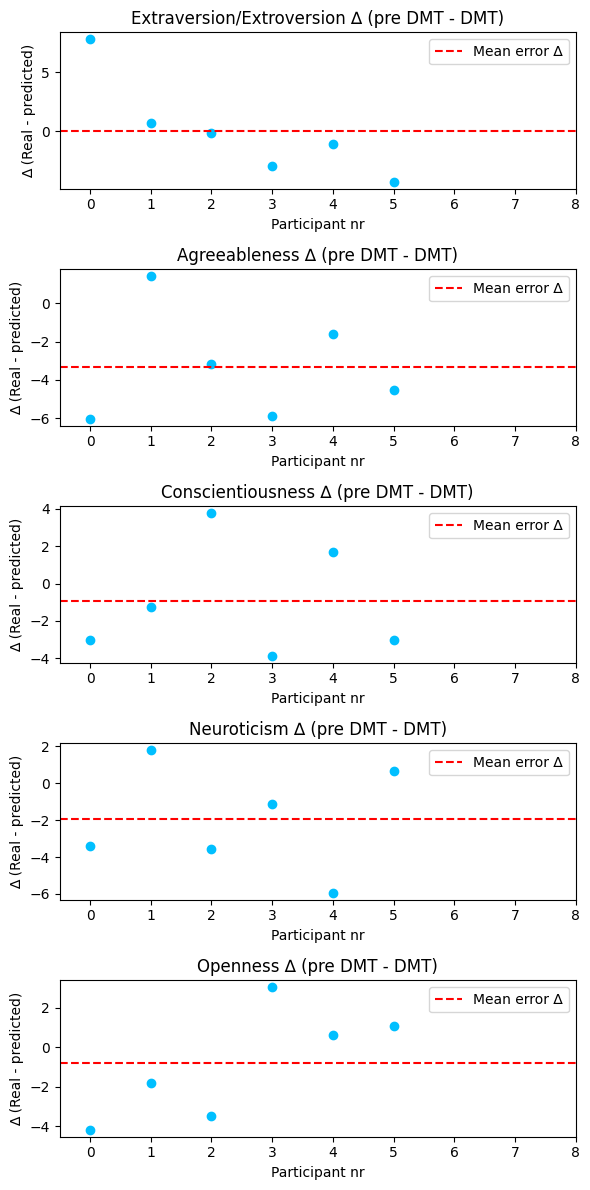

In [ ]:
# Random forest concatenated bands, plotting

results_difference_m2 = []
for k in range(7):
    results_difference_m2.append( pd.DataFrame( columns = ["model", "bands", "Big 5", "pearsonr", "p-value", "MAE", "∆ MAE"] ) )

big_5_features = ["Extraversion/Extroversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness"]

fig, axes = plt.subplots(5, 1, figsize=(6, 12))

# y_error_list
for i in range(5):
    y_test_pre = results_pre_m2[6]['y'][i][0]
    y_pred_pre = results_pre_m2[6]['y'][i][1]
    y_error_pre = abs(abs(y_test_pre) - abs(y_pred_pre))
    y_test_dmt = results_dmt_m2[6]['y'][i][0]
    y_pred_dmt = results_dmt_m2[6]['y'][i][1]
    y_error_dmt = abs(abs(y_test_dmt) - abs(y_pred_dmt))
    y_error = np.round(y_error_pre - y_error_dmt, 5)

    ax = axes[i]
    ax.scatter(range(0, 6), y_error, color = "deepskyblue")
    ax.set_xlim(-0.5, 8)
    ax.set_title(big_5_features[i] + " ∆ (pre DMT - DMT)")
    ax.set_xlabel("Participant nr")
    ax.set_ylabel("∆ (Real - predicted)")

    mean_difference = np.mean(y_error)
    ax.axhline(mean_difference, color = "red", linestyle = "--", label = "Mean error ∆")
    ax.legend()

fig.tight_layout()
plt.show()

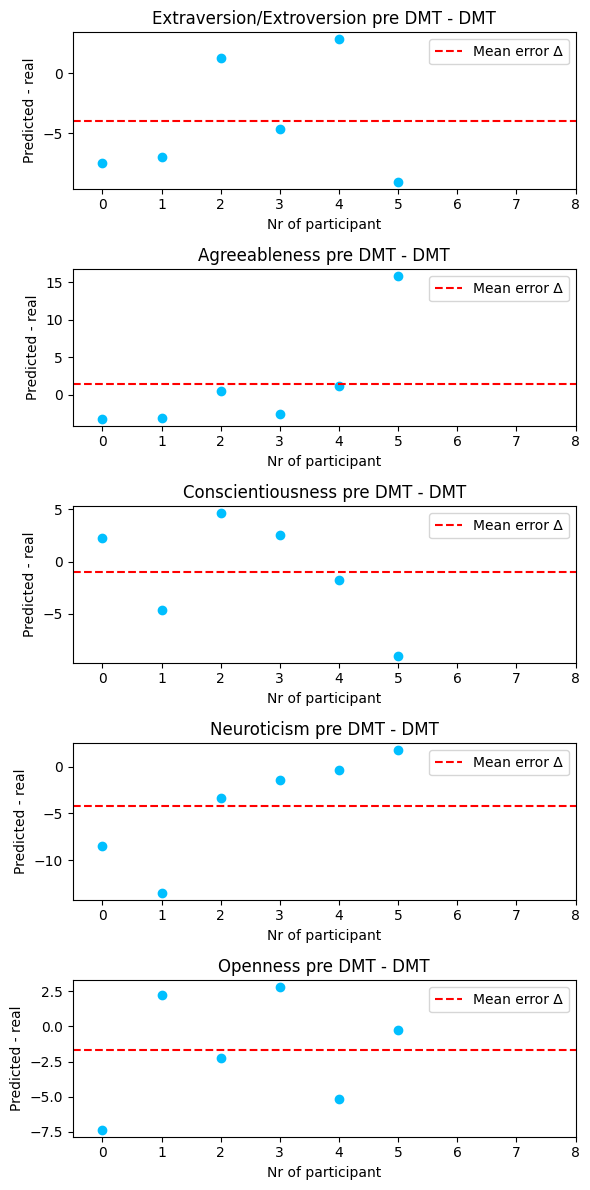

model                       bands                      Big 5  \
0   SVR  Alpha before and after DMT  Extraversion/Extroversion   
1   SVR  Alpha before and after DMT              Agreeableness   
2   SVR  Alpha before and after DMT          Conscientiousness   
3   SVR  Alpha before and after DMT                Neuroticism   
4   SVR  Alpha before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0  (-0.385, -0.375)   (0.45, 0.464)  [4.271, 8.278]  4.007  
1   (-0.715, 0.554)   (0.11, 0.254)  [4.802, 3.392]  -1.41  
2   (0.581, -0.044)  (0.226, 0.934)  [6.205, 7.211]  1.006  
3  (-0.191, -0.142)  (0.717, 0.789)  [3.458, 7.695]  4.237  
4  (-0.152, -0.397)  (0.774, 0.436)  [2.938, 4.596]  1.658

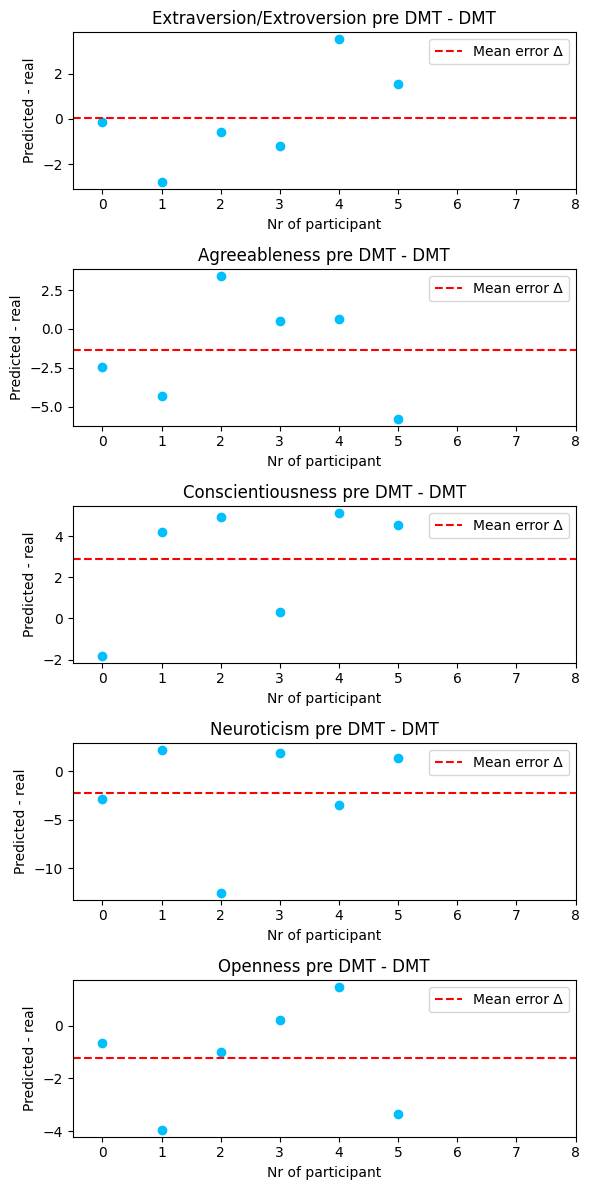

model                      bands                      Big 5  \
0   SVR  Beta before and after DMT  Extraversion/Extroversion   
1   SVR  Beta before and after DMT              Agreeableness   
2   SVR  Beta before and after DMT          Conscientiousness   
3   SVR  Beta before and after DMT                Neuroticism   
4   SVR  Beta before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0    (-0.47, 0.637)  (0.346, 0.174)   [4.992, 4.93] -0.062  
1   (0.296, -0.507)  (0.569, 0.305)  [3.091, 4.421]  1.329  
2     (-0.0, 0.613)    (1.0, 0.195)  [6.055, 3.177] -2.878  
3     (0.7, -0.444)  (0.122, 0.377)  [3.081, 5.317]  2.236  
4  (-0.736, -0.556)  (0.095, 0.252)   [4.27, 5.486]  1.216

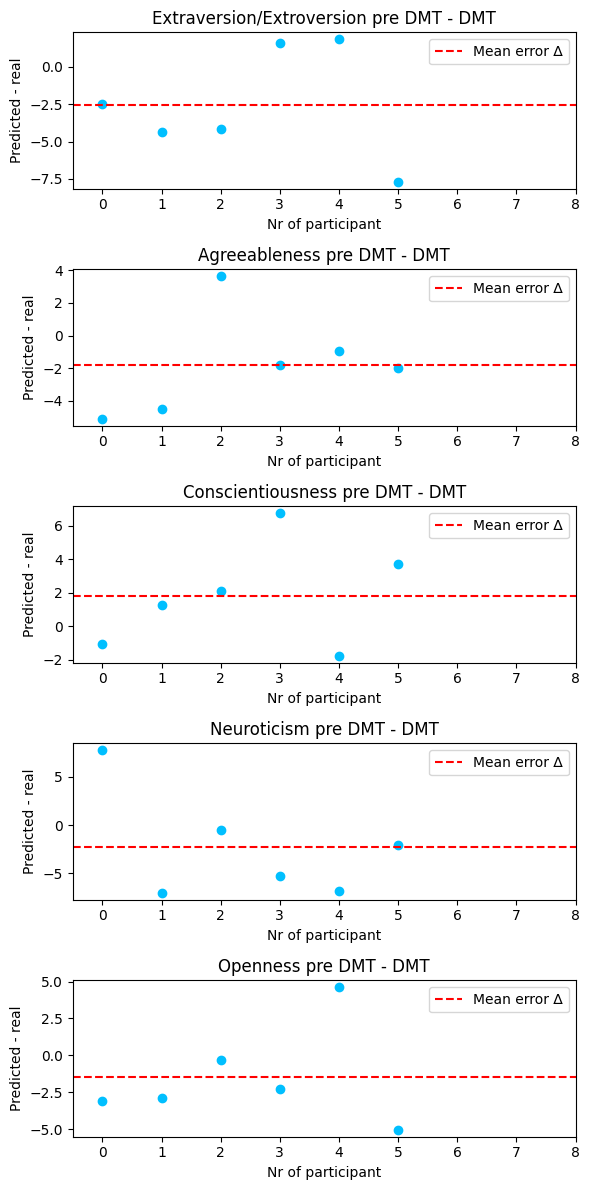

model                       bands                      Big 5  \
0   SVR  Delta before and after DMT  Extraversion/Extroversion   
1   SVR  Delta before and after DMT              Agreeableness   
2   SVR  Delta before and after DMT          Conscientiousness   
3   SVR  Delta before and after DMT                Neuroticism   
4   SVR  Delta before and after DMT                   Openness   

          pearsonr         p-value             MAE  ∆ MAE  
0   (0.466, 0.242)  (0.351, 0.645)  [2.822, 5.387]  2.565  
1   (0.728, 0.055)  (0.101, 0.918)   [3.087, 4.87]  1.782  
2   (0.306, 0.663)  (0.555, 0.151)   [4.791, 2.95]  -1.84  
3   (0.025, 0.556)  (0.962, 0.252)  [3.963, 6.267]  2.303  
4  (-0.365, 0.012)  (0.477, 0.982)  [3.699, 5.188]  1.489

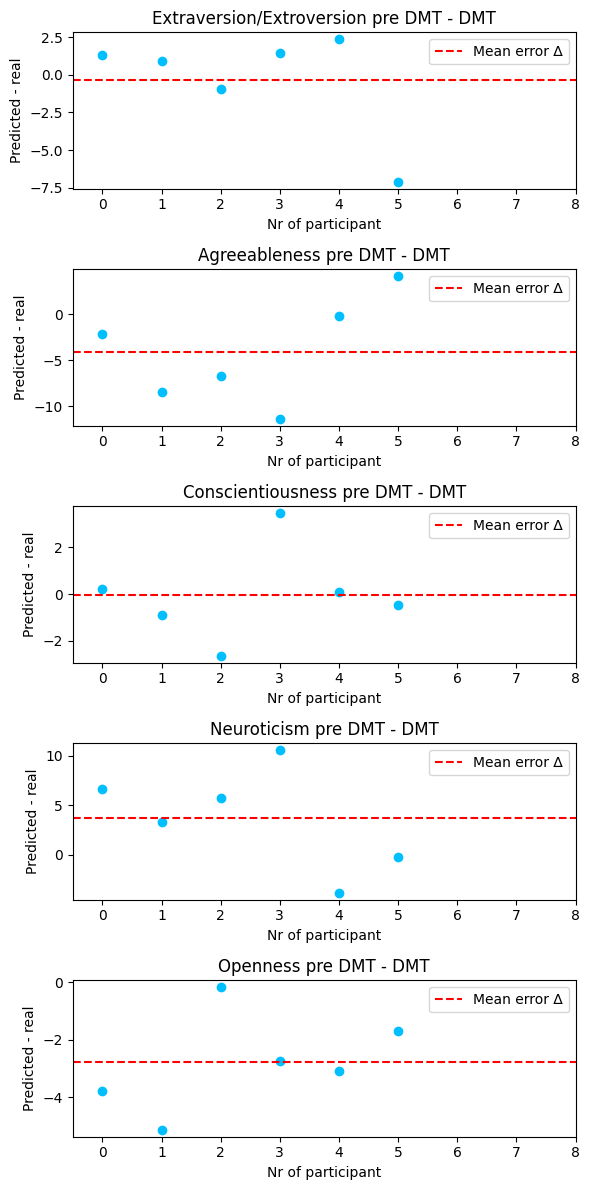

model                         bands                      Big 5  \
0   SVR  Gamma 1 before and after DMT  Extraversion/Extroversion   
1   SVR  Gamma 1 before and after DMT              Agreeableness   
2   SVR  Gamma 1 before and after DMT          Conscientiousness   
3   SVR  Gamma 1 before and after DMT                Neuroticism   
4   SVR  Gamma 1 before and after DMT                   Openness   

          pearsonr         p-value             MAE  ∆ MAE  
0    (nan, -0.326)    (nan, 0.529)  [3.633, 3.967]  0.333  
1  (-0.334, 0.334)  (0.517, 0.518)  [2.802, 6.947]  4.146  
2   (0.443, 0.105)  (0.378, 0.843)  [4.275, 4.318]  0.043  
3   (0.188, 0.004)  (0.722, 0.995)  [7.395, 3.711] -3.684  
4  (0.604, -0.378)   (0.205, 0.46)  [2.345, 5.112]  2.766

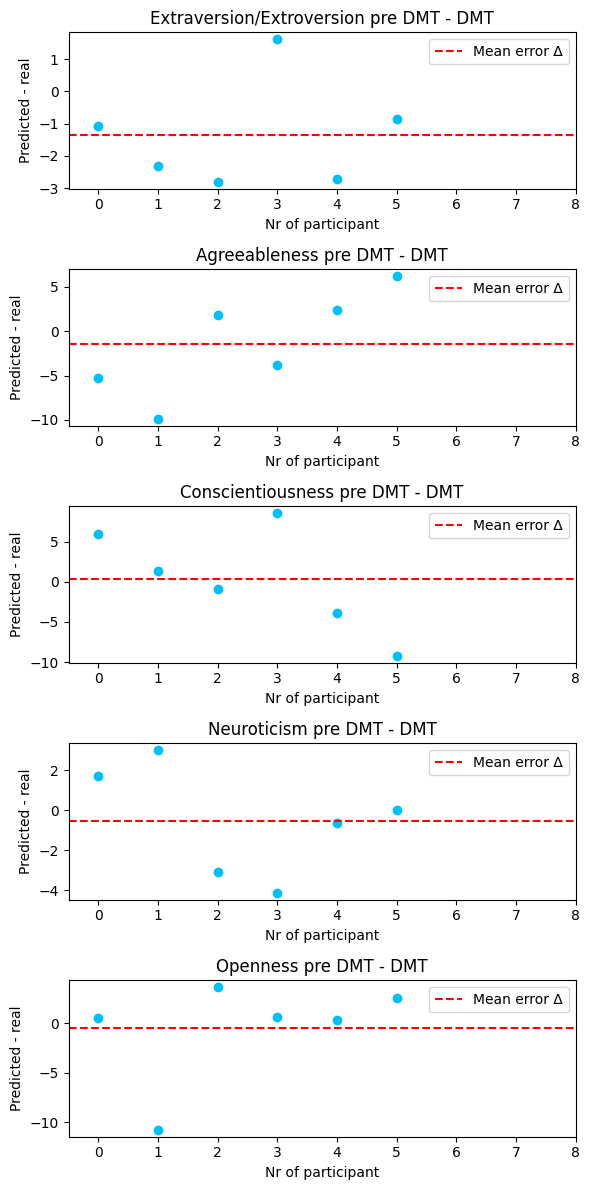

model                         bands                      Big 5  \
0   SVR  Gamma 2 before and after DMT  Extraversion/Extroversion   
1   SVR  Gamma 2 before and after DMT              Agreeableness   
2   SVR  Gamma 2 before and after DMT          Conscientiousness   
3   SVR  Gamma 2 before and after DMT                Neuroticism   
4   SVR  Gamma 2 before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0  (-0.268, -0.152)  (0.608, 0.773)  [4.285, 5.644]  1.359  
1    (-0.922, -0.5)  (0.009, 0.313)  [5.157, 6.561]  1.404  
2    (0.43, -0.168)  (0.395, 0.751)  [5.602, 5.317] -0.285  
3    (0.388, 0.429)  (0.447, 0.395)  [2.562, 3.089]  0.527  
4   (0.011, -0.692)  (0.984, 0.128)  [4.243, 4.783]   0.54

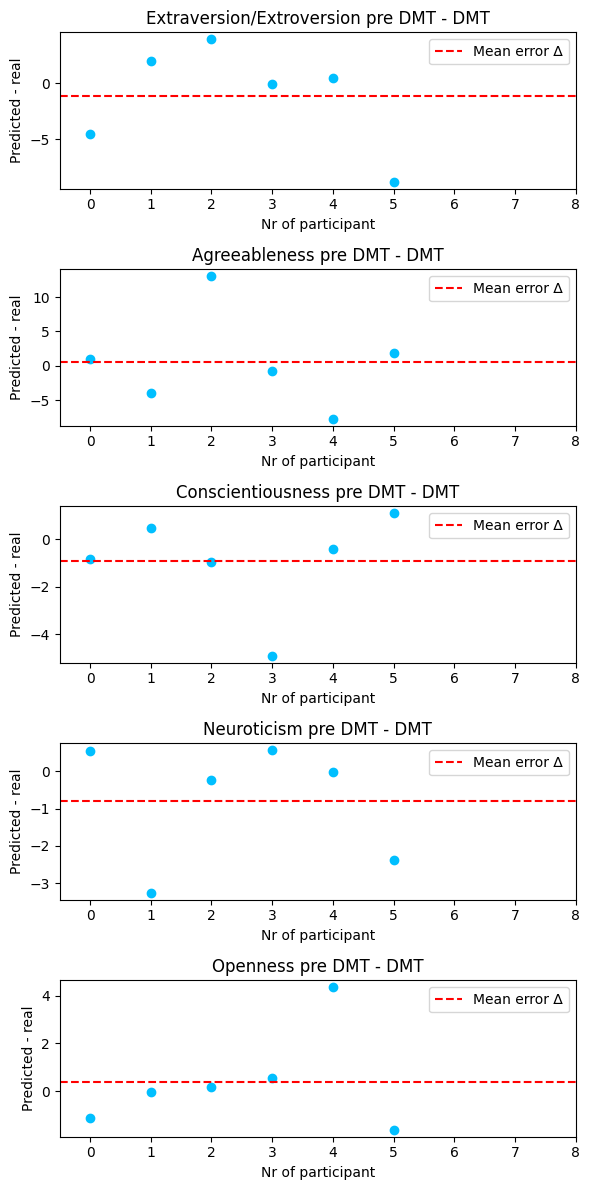

model                       bands                      Big 5  \
0   SVR  Theta before and after DMT  Extraversion/Extroversion   
1   SVR  Theta before and after DMT              Agreeableness   
2   SVR  Theta before and after DMT          Conscientiousness   
3   SVR  Theta before and after DMT                Neuroticism   
4   SVR  Theta before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0   (0.003, -0.631)  (0.996, 0.179)  [3.744, 4.932]  1.187  
1  (-0.285, -0.097)  (0.584, 0.855)  [4.485, 3.893] -0.592  
2   (-0.124, -0.37)   (0.815, 0.47)  [4.512, 5.434]  0.922  
3   (-0.034, 0.046)  (0.949, 0.932)  [2.952, 3.743]  0.791  
4    (-0.31, 0.599)   (0.55, 0.209)  [3.445, 3.054] -0.391

In [ ]:
# Random forest differences by bands

bands_list = list(bands.keys())
big_5_features = ["Extraversion/Extroversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness"]

for band in range(6):
    fig, axes = plt.subplots(5, 1, figsize=(6, 12))
    for i in range(5):

        #Comparing model performance before and after DMT
        results_difference_m2[band].loc[i, "model"] = "SVR"
        results_difference_m2[band].loc[i, "Big 5"] = big_5_features[i]
        results_difference_m2[band].loc[i, "bands"] = "{} before and after DMT".format(bands_list[band])
        results_difference_m2[band].loc[i, "MAE"] = str([round(results_pre_m2[band].loc[i, 'MAE'],3),round(results_dmt_m2[band].loc[i, 'MAE'],3)])
        results_difference_m2[band].loc[i, "∆ MAE"] = round(results_dmt_m2[band].loc[i, 'MAE'] - results_pre_m2[band].loc[i, 'MAE'],3)
        results_difference_m2[band].loc[i, "pearsonr"] = str((round(results_pre_m2[band].loc[i, 'pearsonr'], 3),
                                                    round(results_dmt_m2[band].loc[i, 'pearsonr'], 3)))
        results_difference_m2[band].loc[i, "p-value"] = str((round(results_pre_m2[band].loc[i, 'p-value'], 3),
                                                   round(results_dmt_m2[band].loc[i, 'p-value'], 3)))

        #Calculating error before DMT
        y_test_pre = results_pre_m2[band]['y'][i][0]
        y_pred_pre = results_pre_m2[band]['y'][i][1]
        y_error_pre = abs(abs(y_test_pre) - abs(y_pred_pre))

        #Calcualting error after DMT
        y_test_dmt = results_dmt_m2[band]['y'][i][0]
        y_pred_dmt = results_dmt_m2[band]['y'][i][1]
        y_error_dmt = abs(abs(y_test_dmt) - abs(y_pred_dmt))

        #Calculating imporvement in performance after DMT
        y_error_change_list = []
        y_error_change = np.round(y_error_pre - y_error_dmt, 5)
        y_error_change_list.append(y_error_change)

        #Plotting resoults
        ax = axes[i]
        ax.scatter(range(0, 6), y_error_change, color = "deepskyblue")
        ax.set_xlim(-0.5, 8)

        ax.set_title(big_5_features[i] + " pre DMT - DMT")
        ax.set_xlabel("Nr of participant")
        ax.set_ylabel("Predicted - real")
        ax.plot()

        # Adding line to show mean change in the error rate.
        # Line above 0 indicates imporvement in performance and drop of the error rate after DMT
        mean_difference = np.mean(y_error_change_list)
        ax.axhline(mean_difference, color = "red", linestyle = "--", label = "Mean error ∆")
        ax.legend()

    fig.tight_layout()
    plt.show()
    display(results_difference_m2[band])


In [ ]:
#GPR pre DMT separate bands

kernel = RBF(length_scale=1.0, length_scale_bounds=(1, 10))
feat_selection = SelectKBest(r_regression)
regressor = GPR(kernel=kernel)
pipeline = make_pipeline(feat_selection, regressor)
param_grid = {'gaussianprocessregressor__alpha': [ 0.1, 0.5, 1.0],'gaussianprocessregressor__n_restarts_optimizer': [2, 10, 20],'selectkbest__k': [10, 15, 20]}

#creating Panda DataFrame to save metric values
results_pre_m3 = []
for k in range(7):
  results_pre_m3.append(pd.DataFrame(  columns = ["band", "model", "MAE", "pearsonr", "p-value", 'y'] ))

nr=0

for band in list(bands.keys())[0:6]:
  for i in range (5):
    X_train, X_test, y_train, y_test = train_test_split(bands[band], big_5_pre[i], test_size=0.2, random_state=0, shuffle=True)
    X_train = X_train.values
    X_test = X_test.values

    # Polynomial features
    polynomial_features = PolynomialFeatures(degree=2, include_bias=True)
    X_train_poly = polynomial_features.fit_transform(X_train)
    X_test_poly = polynomial_features.transform(X_test)

    # Grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'r2')
    grid_search.fit(X_train_poly, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_poly)

    score = mean_absolute_error(y_test, y_pred)
    corr_coef, p_value = pearsonr(y_test, y_pred)
    results_pre_m3[nr].loc[i,"band"] = band
    results_pre_m3[nr].loc[i,"model"] = best_model
    results_pre_m3[nr].loc[i,"MAE"] = score
    results_pre_m3[nr].loc[i,"pearsonr"] = corr_coef
    results_pre_m3[nr].loc[i,"p-value"] = p_value
    results_pre_m3[nr].loc[i, "y"] = [y_test, y_pred]

  nr+=1

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian

In [ ]:
#GPR pre DMT all bands concatenated

kernel = RBF(length_scale = 1.0, length_scale_bounds = (1, 10))
feat_selection = SelectKBest(r_regression)
regressor = GPR(kernel = kernel)
pipeline = make_pipeline(feat_selection, regressor)
param_grid = {'gaussianprocessregressor__alpha': [ 0.1, 0.5, 1.0],'gaussianprocessregressor__n_restarts_optimizer': [2, 10, 20],'selectkbest__k': [10, 150, 200]}


X_train_all = []
X_train_all = np.array(X_train_all)
X_test_all = []
X_test_all = np.array(X_test_all)

for band in list(bands.keys())[0:6]:
    X_train, X_test = train_test_split(bands[band], test_size = 0.2, random_state = 0, shuffle = True)
    X_train = X_train.values
    X_test = X_test.values
    if len(X_train_all) == 0:
        X_train_all = X_train
        X_test_all = X_test
    else:
        X_train_all = np.hstack((X_train_all,X_train))
        X_test_all = np.hstack((X_test_all,X_test))

#Polynomial features for X
polynomial_features = PolynomialFeatures(degree = 2, include_bias  =True)
X_train_poly = polynomial_features.fit_transform(X_train_all)
X_test_poly = polynomial_features.transform(X_test_all)

for i in range (5):
    y_train, y_test = train_test_split(big_5_pre[i] , test_size=0.2, random_state=0, shuffle=True)
    print(i)

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train_poly, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_poly)

    score = mean_absolute_error(y_test, y_pred)
    corr_coef, p_value = pearsonr(y_test, y_pred)
    results_pre_m3[6].loc[i, "band"] = "All bands pre DMT"
    results_pre_m3[6].loc[i, "model"] = best_model
    results_pre_m3[6].loc[i, "MAE"] = score
    results_pre_m3[6].loc[i, "pearsonr"] = corr_coef
    results_pre_m3[6].loc[i, "p-value"] = p_value
    results_pre_m3[6].loc[i, "y"] = [y_test, y_pred]

0


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value fo

1


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value fo

2


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value fo

3


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value fo

4


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value fo

In [ ]:
#GPR DMT separate bands

kernel = RBF(length_scale = 1.0, length_scale_bounds = (1, 10))
feat_selection = SelectKBest(r_regression)
regressor = GPR(kernel = kernel)
pipeline = make_pipeline(feat_selection, regressor)
param_grid = {'gaussianprocessregressor__alpha': [ 0.1, 0.5, 1.0],'gaussianprocessregressor__n_restarts_optimizer': [2, 10, 20],'selectkbest__k': [10, 15, 20]}

#creating Panda DataFrame to save metric values
results_dmt_m3 = []
for k in range(7):
  results_dmt_m3.append(pd.DataFrame( columns = ["band", "model", "MAE", "pearsonr", "p-value", 'y'] ) )

nr=0

for band in list(bands.keys())[6:12]:
  for i in range (5):
    X_train, X_test, y_train, y_test = train_test_split(bands[band], big_5_dmt[i], test_size = 0.2, random_state = 0, shuffle = True)
    X_train = X_train.values
    X_test = X_test.values

    #Polynomial features
    polynomial_features = PolynomialFeatures(degree = 2, include_bias = True)
    X_train_poly = polynomial_features.fit_transform(X_train)
    X_test_poly = polynomial_features.transform(X_test)

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'r2')
    grid_search.fit(X_train_poly, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_poly)

    score = mean_absolute_error(y_test, y_pred)
    corr_coef, p_value = pearsonr(y_test, y_pred)
    results_dmt_m3[nr].loc[i,"band"] = band
    results_dmt_m3[nr].loc[i,"model"] = best_model
    results_dmt_m3[nr].loc[i,"MAE"] = score
    results_dmt_m3[nr].loc[i,"pearsonr"] = corr_coef
    results_dmt_m3[nr].loc[i,"p-value"] = p_value
    results_dmt_m3[nr].loc[i, "y"] = [y_test, y_pred]

  nr += 1

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 10. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 10. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussi

In [ ]:
# GPR DMT all bands concatenated

kernel = RBF(length_scale = 1.0, length_scale_bounds = (1, 10))
feat_selection = SelectKBest(r_regression)
regressor = GPR(kernel = kernel)
pipeline = make_pipeline(feat_selection, regressor)
param_grid = {'gaussianprocessregressor__alpha': [ 0.1, 0.5, 1.0],'gaussianprocessregressor__n_restarts_optimizer': [2, 10, 20],'selectkbest__k': [10, 15, 20]}


X_train_all = []
X_train_all = np.array(X_train_all)
X_test_all = []
X_test_all = np.array(X_test_all)

for band in list(bands.keys())[6:12]:
    X_train, X_test = train_test_split(bands[band], test_size = 0.2, random_state = 0, shuffle = True)
    X_train = X_train.values
    X_test = X_test.values
    if len(X_train_all) == 0:
        X_train_all = X_train
        X_test_all = X_test
    else:
        X_train_all = np.hstack((X_train_all,X_train))
        X_test_all = np.hstack((X_test_all,X_test))

#Extrtacting polynomial features from X
polynomial_features = PolynomialFeatures(degree = 2, include_bias = True)
X_train_poly = polynomial_features.fit_transform(X_train_all)
X_test_poly = polynomial_features.transform(X_test_all)

for i in range (5):
    y_train, y_test = train_test_split(big_5_dmt[i], test_size = 0.2, random_state = 0, shuffle = True)

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'r2')
    grid_search.fit(X_train_poly, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_poly)

    score = mean_absolute_error(y_test, y_pred)
    corr_coef, p_value = pearsonr(y_test, y_pred)
    results_dmt_m3[6].loc[i, "band"] = "All bands DMT"
    results_dmt_m3[6].loc[i, "model"] = best_model
    results_dmt_m3[6].loc[i, "MAE"] = score
    results_dmt_m3[6].loc[i, "pearsonr"] = corr_coef
    results_dmt_m3[6].loc[i, "p-value"] = p_value
    results_dmt_m3[6].loc[i, "y"] = [y_test, y_pred]

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value fo

In [ ]:
# GPR concatenated bands, models performance comparison

model_info_gpr = []
big_5_features = ["Extraversion/Extroversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness"]

for i in range(5):
    pipeline = results_pre_m3[6]['model'][i]
    model = pipeline.named_steps['gaussianprocessregressor']
    model_name = model.__class__.__name__
    score = [round(results_pre_m3[6].loc[i, "MAE"], 3), round(results_dmt_m3[6].loc[i, "MAE"], 3)]
    score_difference = round(results_dmt_m3[6].loc[i, "MAE"], 3) - round(results_pre_m3[6].loc[i, "MAE"], 3)
    corr_coef = [round(results_pre_m3[6].loc[i, "pearsonr"], 3), round(results_dmt_m3[6].loc[i, "pearsonr"], 3)]
    p_value = [round(results_pre_m3[6].loc[i, "p-value"], 3), round(results_dmt_m3[6].loc[i, "p-value"], 3)]

    model_dict_gpr = {
        "Model": model_name,
        "band": "All bands before and after DMT",
        "Big 5": big_5_features[i],
        "pearsonr": corr_coef,
        "p-value": p_value,
        "MAE": score,
        "∆ MAE": score_difference
    }
    model_info_gpr.append(model_dict_gpr)

model_df_gpr = pd.DataFrame(model_info_gpr)
display(model_df_gpr)

Model                            band  \
0  GaussianProcessRegressor  All bands before and after DMT   
1  GaussianProcessRegressor  All bands before and after DMT   
2  GaussianProcessRegressor  All bands before and after DMT   
3  GaussianProcessRegressor  All bands before and after DMT   
4  GaussianProcessRegressor  All bands before and after DMT   

                       Big 5         pearsonr         p-value             MAE  \
0  Extraversion/Extroversion  [0.337, -0.628]  [0.514, 0.182]  [3.313, 3.377]   
1              Agreeableness  [0.784, -0.153]  [0.065, 0.772]  [2.224, 2.265]   
2          Conscientiousness   [0.216, 0.274]    [0.681, 0.6]  [3.533, 3.421]   
3                Neuroticism   [0.815, 0.276]  [0.048, 0.596]  [1.866, 2.716]   
4                   Openness   [-0.744, -0.7]   [0.09, 0.122]  [2.388, 3.327]   

   ∆ MAE  
0  0.064  
1  0.041  
2 -0.112  
3  0.850  
4  0.939

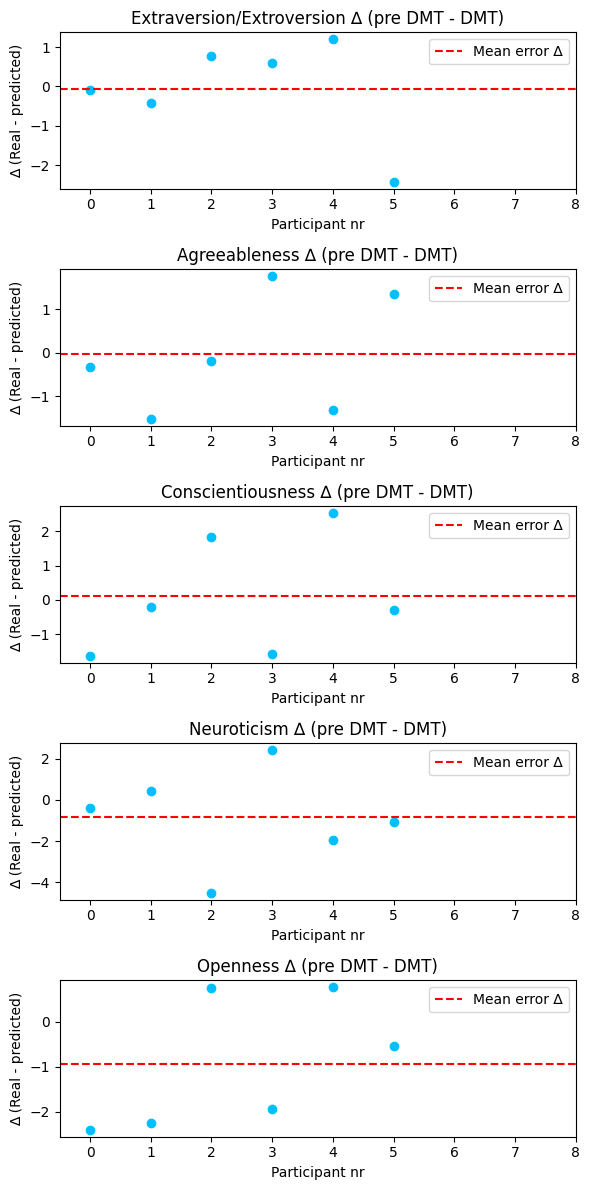

In [ ]:
# GPR concatenated bands, plotting

results_difference_m3 = []
for k in range(7):
    results_difference_m3.append( pd.DataFrame( columns = ["model", "bands", "Big 5", "pearsonr", "p-value", "MAE", "∆ MAE"] ) )

big_5_features = ["Extraversion/Extroversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness"]

fig, axes = plt.subplots(5, 1, figsize=(6, 12))

# y_error_list
for i in range(5):
    y_test_pre = results_pre_m3[6]['y'][i][0]
    y_pred_pre = results_pre_m3[6]['y'][i][1]
    y_error_pre = abs(abs(y_test_pre) - abs(y_pred_pre))
    y_test_dmt = results_dmt_m3[6]['y'][i][0]
    y_pred_dmt = results_dmt_m3[6]['y'][i][1]
    y_error_dmt = abs(abs(y_test_dmt) - abs(y_pred_dmt))
    y_error = np.round(y_error_pre - y_error_dmt, 5)

    ax = axes[i]
    ax.scatter(range(0, 6), y_error, color = "deepskyblue")
    ax.set_xlim(-0.5, 8)
    ax.set_title(big_5_features[i] + " ∆ (pre DMT - DMT)")
    ax.set_xlabel("Participant nr")
    ax.set_ylabel("∆ (Real - predicted)")

    mean_difference = np.mean(y_error)
    ax.axhline(mean_difference, color = "red", linestyle = "--", label = "Mean error ∆")
    ax.legend()

fig.tight_layout()
plt.show()

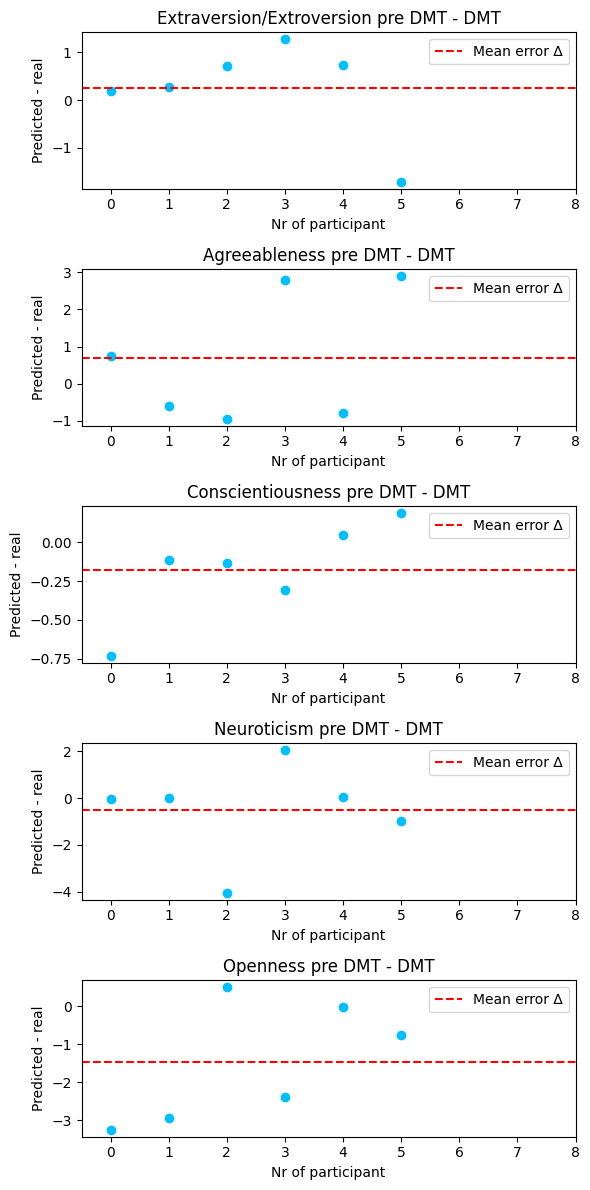

model                       bands                      Big 5  \
0   SVR  Alpha before and after DMT  Extraversion/Extroversion   
1   SVR  Alpha before and after DMT              Agreeableness   
2   SVR  Alpha before and after DMT          Conscientiousness   
3   SVR  Alpha before and after DMT                Neuroticism   
4   SVR  Alpha before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0    (0.349, 0.133)  (0.498, 0.801)   [3.38, 3.136] -0.244  
1    (0.428, 0.261)  (0.397, 0.617)  [2.821, 2.133] -0.688  
2   (-0.484, 0.171)   (0.33, 0.746)  [3.078, 3.253]  0.175  
3    (0.876, 0.008)  (0.022, 0.988)    [2.204, 2.7]  0.496  
4  (-0.057, -0.655)  (0.915, 0.158)  [2.421, 3.891]  1.471

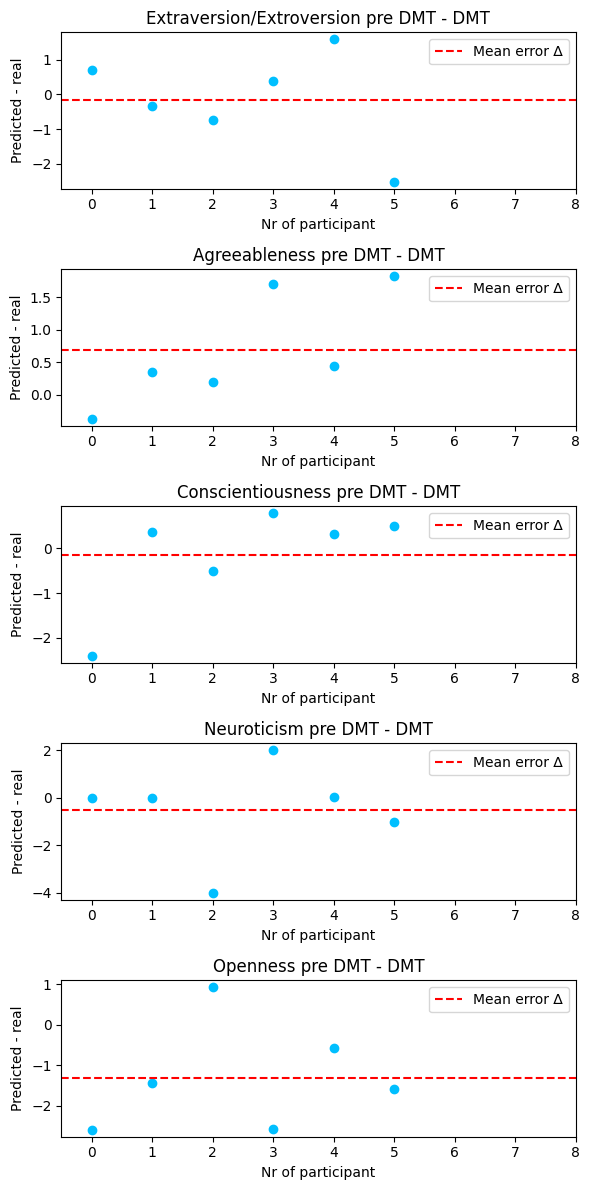

model                      bands                      Big 5  \
0   SVR  Beta before and after DMT  Extraversion/Extroversion   
1   SVR  Beta before and after DMT              Agreeableness   
2   SVR  Beta before and after DMT          Conscientiousness   
3   SVR  Beta before and after DMT                Neuroticism   
4   SVR  Beta before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0   (-0.18, -0.715)   (0.732, 0.11)    [3.54, 3.69]   0.15  
1   (-0.337, 0.424)  (0.513, 0.402)   [2.843, 2.15] -0.693  
2  (-0.604, -0.265)  (0.204, 0.612)  [3.351, 3.508]  0.158  
3    (0.806, 0.559)  (0.053, 0.249)  [2.209, 2.711]  0.501  
4  (-0.863, -0.736)  (0.027, 0.095)  [1.952, 3.255]  1.303

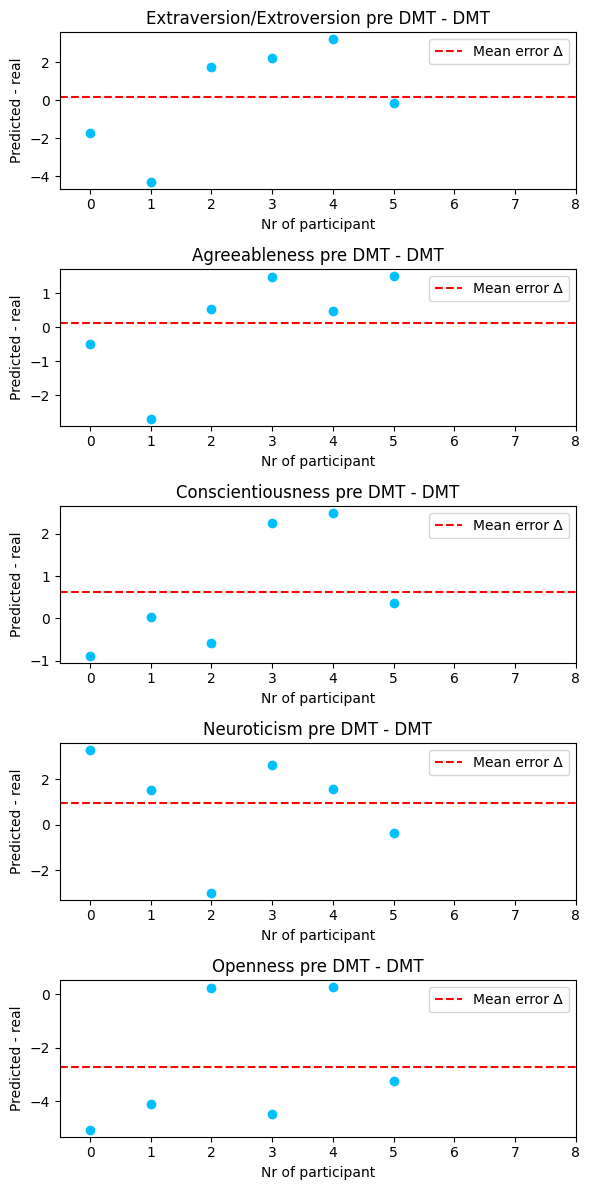

model                       bands                      Big 5  \
0   SVR  Delta before and after DMT  Extraversion/Extroversion   
1   SVR  Delta before and after DMT              Agreeableness   
2   SVR  Delta before and after DMT          Conscientiousness   
3   SVR  Delta before and after DMT                Neuroticism   
4   SVR  Delta before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0    (0.303, 0.403)  (0.559, 0.429)  [3.422, 3.263] -0.159  
1    (0.467, 0.176)  (0.351, 0.738)  [2.807, 2.664] -0.143  
2     (0.361, 0.18)  (0.483, 0.733)  [4.152, 3.537] -0.615  
3  (-0.746, -0.284)  (0.089, 0.585)  [3.652, 2.712]  -0.94  
4  (-0.162, -0.337)  (0.759, 0.514)  [1.968, 4.693]  2.724

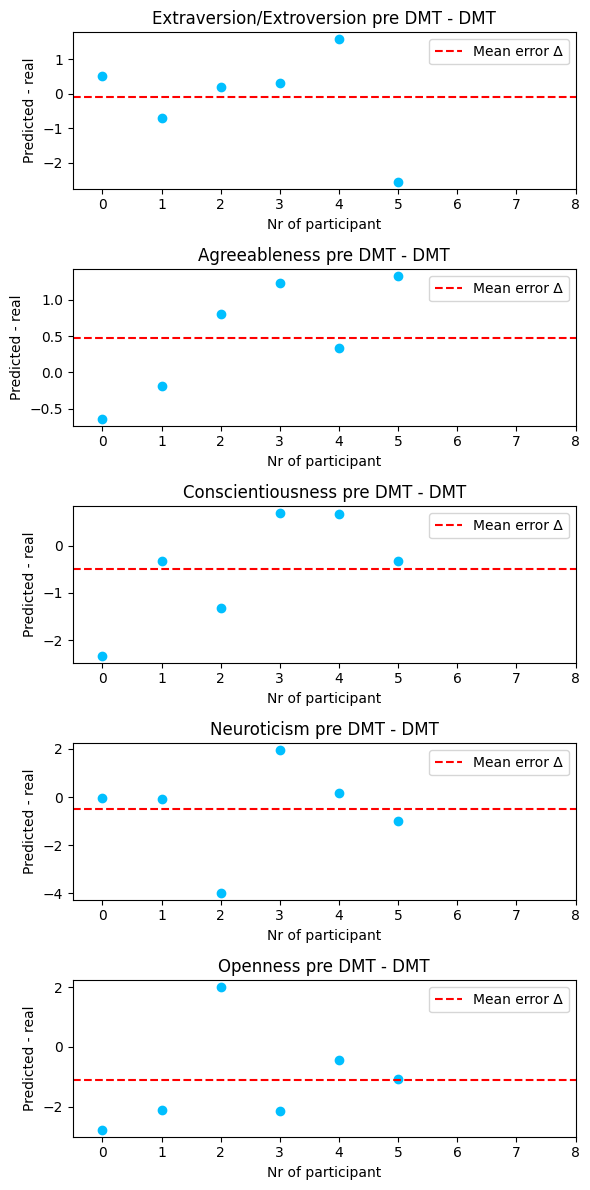

model                         bands                      Big 5  \
0   SVR  Gamma 1 before and after DMT  Extraversion/Extroversion   
1   SVR  Gamma 1 before and after DMT              Agreeableness   
2   SVR  Gamma 1 before and after DMT          Conscientiousness   
3   SVR  Gamma 1 before and after DMT                Neuroticism   
4   SVR  Gamma 1 before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0  (-0.201, -0.355)   (0.703, 0.49)  [3.392, 3.496]  0.103  
1   (0.612, -0.096)  (0.197, 0.857)  [2.825, 2.345] -0.479  
2  (-0.633, -0.621)  (0.177, 0.188)  [3.011, 3.501]   0.49  
3   (-0.159, 0.549)  (0.763, 0.259)   [2.21, 2.707]  0.496  
4  (-0.287, -0.665)  (0.582, 0.149)  [2.495, 3.592]  1.097

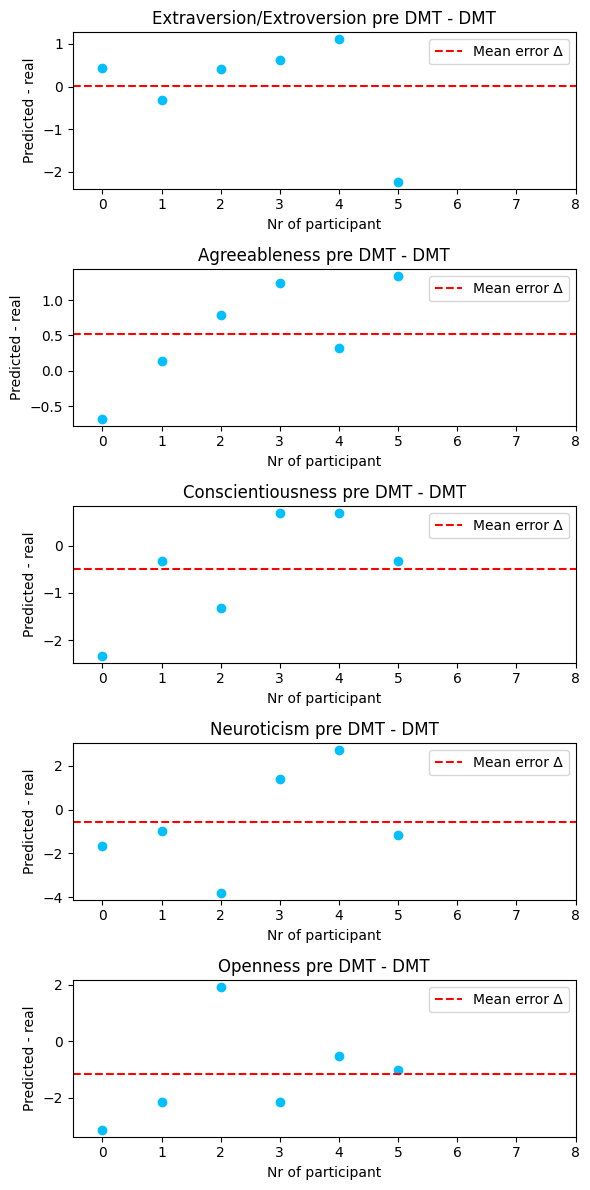

model                         bands                      Big 5  \
0   SVR  Gamma 2 before and after DMT  Extraversion/Extroversion   
1   SVR  Gamma 2 before and after DMT              Agreeableness   
2   SVR  Gamma 2 before and after DMT          Conscientiousness   
3   SVR  Gamma 2 before and after DMT                Neuroticism   
4   SVR  Gamma 2 before and after DMT                   Openness   

           pearsonr         p-value             MAE  ∆ MAE  
0   (0.339, -0.552)  (0.511, 0.256)  [3.391, 3.384] -0.007  
1     (0.83, -0.17)  (0.041, 0.748)  [2.832, 2.307] -0.525  
2  (-0.614, -0.647)  (0.195, 0.165)   [3.01, 3.501]   0.49  
3   (-0.287, 0.395)  (0.581, 0.438)   [2.21, 2.789]  0.579  
4   (0.036, -0.571)  (0.946, 0.236)  [2.488, 3.663]  1.176

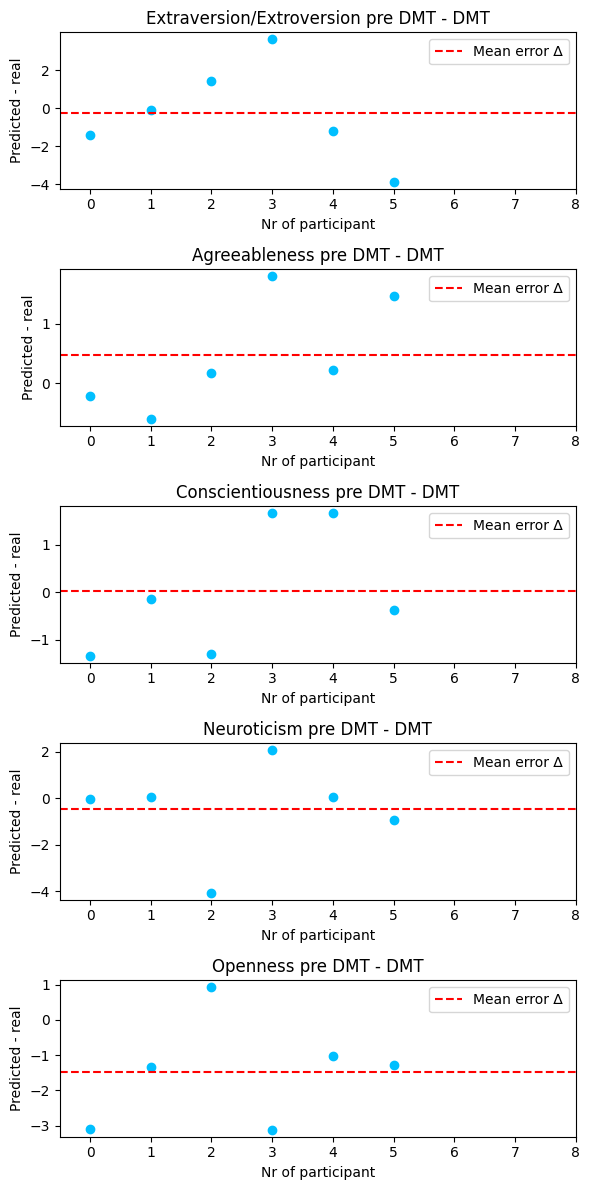

model                       bands                      Big 5  \
0   SVR  Theta before and after DMT  Extraversion/Extroversion   
1   SVR  Theta before and after DMT              Agreeableness   
2   SVR  Theta before and after DMT          Conscientiousness   
3   SVR  Theta before and after DMT                Neuroticism   
4   SVR  Theta before and after DMT                   Openness   

          pearsonr         p-value             MAE  ∆ MAE  
0  (0.438, -0.419)  (0.385, 0.409)  [3.421, 3.681]   0.26  
1   (-0.3, -0.892)  (0.564, 0.017)  [2.834, 2.362] -0.471  
2  (-0.316, -0.35)  (0.542, 0.497)  [3.518, 3.489] -0.029  
3  (0.698, -0.322)  (0.123, 0.534)  [2.209, 2.695]  0.486  
4  (0.028, -0.305)  (0.958, 0.557)  [2.464, 3.944]   1.48

In [ ]:
# GPR differences by bands

bands_list = list(bands.keys())
big_5_features = ["Extraversion/Extroversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness"]

for band in range(6):
    fig, axes = plt.subplots(5, 1, figsize=(6, 12))
    for i in range(5):

        #Comparing model performance before and after DMT
        results_difference_m3[band].loc[i, "model"] = "SVR"
        results_difference_m3[band].loc[i, "Big 5"] = big_5_features[i]
        results_difference_m3[band].loc[i, "bands"] = "{} before and after DMT".format(bands_list[band])
        results_difference_m3[band].loc[i, "MAE"] = str([round(results_pre_m3[band].loc[i, 'MAE'],3),round(results_dmt_m3[band].loc[i, 'MAE'],3)])
        results_difference_m3[band].loc[i, "∆ MAE"] = round(results_dmt_m3[band].loc[i, 'MAE'] - results_pre_m3[band].loc[i, 'MAE'],3)
        results_difference_m3[band].loc[i, "pearsonr"] = str((round(results_pre_m3[band].loc[i, 'pearsonr'], 3),
                                                    round(results_dmt_m3[band].loc[i, 'pearsonr'], 3)))
        results_difference_m3[band].loc[i, "p-value"] = str((round(results_pre_m3[band].loc[i, 'p-value'], 3),
                                                   round(results_dmt_m3[band].loc[i, 'p-value'], 3)))

        #Calculating error before DMT
        y_test_pre = results_pre_m3[band]['y'][i][0]
        y_pred_pre = results_pre_m3[band]['y'][i][1]
        y_error_pre = abs(abs(y_test_pre) - abs(y_pred_pre))

        #Calcualting error after DMT
        y_test_dmt = results_dmt_m3[band]['y'][i][0]
        y_pred_dmt = results_dmt_m3[band]['y'][i][1]
        y_error_dmt = abs(abs(y_test_dmt) - abs(y_pred_dmt))

        #Calculating imporvement in performance after DMT
        y_error_change_list = []
        y_error_change = np.round(y_error_pre - y_error_dmt, 5)
        y_error_change_list.append(y_error_change)

        #Plotting resoults
        ax = axes[i]
        ax.scatter(range(0, 6), y_error_change, color="deepskyblue")
        ax.set_xlim(-0.5, 8)

        ax.set_title(big_5_features[i] + " pre DMT - DMT")
        ax.set_xlabel("Nr of participant")
        ax.set_ylabel("Predicted - real")
        ax.plot()

        # Adding line to show mean change in the error rate.
        # Line above 0 indicates imporvement in performance and drop of the error rate after DMT
        mean_difference = np.mean(y_error_change_list)
        ax.axhline(mean_difference, color = "red", linestyle = "--", label = "Mean error ∆")
        ax.legend()

    fig.tight_layout()
    plt.show()
    display(results_difference_m3[band])
